# Do Interictal Discharges Affect Functional Connectivity

author: Jeni Stiso (jeni.stiso@gmail.com)

words

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from statsmodels.stats.anova import AnovaRM
import palettable
import statsmodels.api as sm
from sklearn.metrics.pairwise import euclidean_distances
import itertools

%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster')
sns.set_style("whitegrid")

In [2]:
# directories - point this at you RAM data
RAM_dir = '/Volumes/bassett-data/Jeni/RAM/'
parcel_dir = '/Users/stiso/Documents/parcellations/'
win = 1
detector = '' # '_delphos' or ''

# load data
net_data = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/network_stats{detector}.csv', index_col=0)
node_data = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/node_stats{detector}.csv', index_col=0)

# drop duplicates
net_data.drop_duplicates(inplace=True)
node_data.drop_duplicates(inplace=True)

Check the data

In [3]:
net_data.head(10)

band_measure  n_tp  str_beta_bin  str_beta_num  str_beta_spr  \
1         alpha_aec   107     -0.001170     -0.003834     -0.000906   
2   alpha_aec_ortho   107      0.003289      0.001749     -0.000120   
3         alpha_coh   107     -0.002831     -0.001307     -0.000162   
4      alpha_im_coh   107     -0.002251     -0.001216     -0.000052   
5        alpha_iplv   107     -0.011551     -0.018571     -0.000731   
6         alpha_plv   107     -0.005822     -0.007193     -0.001030   
7          beta_aec   107      0.003067      0.000166      0.000331   
8    beta_aec_ortho   107      0.000570     -0.002487      0.000517   
9          beta_coh   107      0.004299      0.004198      0.000761   
10      beta_im_coh   107      0.002699      0.002134      0.000615   

    ti_beta_bin  ti_beta_num  ti_beta_spr  str_soz_beta_bin  str_soz_beta_num  \
1     -0.003215     0.007433     0.001236         -0.002027         -0.003219   
2     -0.038618    -0.040827    -0.004130          0.008756          0.011889   
3      0.087585     0.122493    -0.000073         -0.006692         -0.005622   
4      0.007866     0.010105    -0.000839         -0.006423         -0.004927   
5      0.035004     0.052945     0.002363         -0.019025         -0.032505   
6      0.095681     0.141000     0.008685         -0.004759         -0.008914   
7     -0.015171     0.013705    -0.004430          0.004176          0.006326   
8      0.008797     0.038698     0.000097          0.000467          0.003855   
9     -0.056966    -0.043601    -0.016674          0.003423          0.003483   
10    -0.019914    -0.036505    -0.007572          0.002755          0.002506   

          ...          str_wm_beta_spr  str_gm_beta_bin  str_gm_beta_num  \
1         ...                -0.000686        -0.009536        -0.014797   
2         ...                 0.000131        -0.004099        -0.014693   
3         ...                -0.000051        -0.000563         0.005013   
4         ...                 0.000098        -0.002076         0.000317   
5         ...                -0.000905        -0.004416        -0.009796   
6         ...                -0.001383         0.004168         0.005455   
7         ...                 0.000503         0.008363         0.011933   
8         ...                 0.000601         0.008173         0.013259   
9         ...                 0.000634         0.012737         0.016546   
10        ...                 0.000576         0.010538         0.014412   

    str_gm_beta_spr    subj  hand   age  gender race  str_brid_beta_num  
1         -0.001593  R1170J     R  20.0       M  2.0                NaN  
2         -0.000284  R1170J     R  20.0       M  2.0                NaN  
3         -0.000229  R1170J     R  20.0       M  2.0                NaN  
4         -0.000271  R1170J     R  20.0       M  2.0                NaN  
5         -0.000323  R1170J     R  20.0       M  2.0                NaN  
6         -0.000135  R1170J     R  20.0       M  2.0                NaN  
7         -0.000099  R1170J     R  20.0       M  2.0                NaN  
8          0.000262  R1170J     R  20.0       M  2.0                NaN  
9          0.001002  R1170J     R  20.0       M  2.0                NaN  
10         0.000721  R1170J     R  20.0       M  2.0                NaN  

[10 rows x 40 columns]

In [4]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4890 entries, 1 to 4980
Data columns (total 40 columns):
band_measure              4890 non-null object
n_tp                      4890 non-null int64
str_beta_bin              4380 non-null float64
str_beta_num              4860 non-null float64
str_beta_spr              4860 non-null float64
ti_beta_bin               4380 non-null float64
ti_beta_num               4860 non-null float64
ti_beta_spr               4860 non-null float64
str_soz_beta_bin          3180 non-null float64
str_soz_beta_num          3510 non-null float64
str_soz_beta_spr          3510 non-null float64
str_not_soz_beta_num      3510 non-null float64
str_spike_beta_num        3420 non-null float64
str_not_soz_beta_spr      3510 non-null float64
str_not_soz_beta_bin      3180 non-null float64
str_spike_beta_bin        3090 non-null float64
str_spike_beta_spr        3420 non-null float64
str_not_spike_beta_bin    3090 non-null float64
fc_measure                4890 n

In [5]:
net_data.describe()

n_tp  str_beta_bin  str_beta_num  str_beta_spr  ti_beta_bin  \
count  4890.000000   4380.000000   4860.000000   4860.000000  4380.000000   
mean    940.269939      0.002516      0.000549      0.000926    -0.008899   
std    1019.335640      0.037365      0.022393      0.025100     0.098205   
min      15.000000     -0.329691     -0.367578     -0.075145    -1.876298   
25%     260.000000     -0.000762     -0.002344     -0.000205    -0.023194   
50%     632.000000      0.000803      0.000127      0.000259    -0.003403   
75%    1112.000000      0.003609      0.002709      0.001087     0.010442   
max    5613.000000      2.246198      0.706183      1.733515     1.455187   

       ti_beta_num  ti_beta_spr  str_soz_beta_bin  str_soz_beta_num  \
count  4860.000000  4860.000000       3180.000000       3510.000000   
mean      0.002524    -0.000811          0.002446          0.000821   
std       0.187606     0.029475          0.017159          0.032224   
min      -2.244225    -0.376796         -0.218338         -0.681154   
25%      -0.018236    -0.005576         -0.001423         -0.003323   
50%       0.001466    -0.000438          0.001263          0.000313   
75%       0.022363     0.003345          0.005676          0.004328   
max       5.348567     0.613751          0.492492          0.283676   

       str_soz_beta_spr        ...          str_depth_beta_spr  \
count       3510.000000        ...                 4410.000000   
mean           0.001060        ...                    0.000786   
std            0.007032        ...                    0.021047   
min           -0.043499        ...                   -0.075145   
25%           -0.000275        ...                   -0.000282   
50%            0.000374        ...                    0.000213   
75%            0.001805        ...                    0.001059   
max            0.228109        ...                    1.375937   

       str_wm_beta_bin  str_wm_beta_num  str_wm_beta_spr  str_gm_beta_bin  \
count      3300.000000      3690.000000      3690.000000      3300.000000   
mean          0.001131        -0.000778         0.000504         0.001470   
std           0.015722         0.027288         0.004576         0.013721   
min          -0.339047        -0.391444        -0.077066        -0.204817   
25%          -0.001672        -0.004257        -0.000326        -0.001181   
50%           0.000576        -0.000161         0.000197         0.000535   
75%           0.004089         0.002910         0.001266         0.003626   
max           0.171254         0.431161         0.053571         0.170804   

       str_gm_beta_num  str_gm_beta_spr          age         race  \
count     3.690000e+03      3690.000000  4860.000000  4680.000000   
mean     -6.155346e-04         0.000536    36.018519     3.012821   
std       2.403170e-02         0.003855    11.837275     1.209002   
min      -4.921826e-01        -0.049073    16.000000     1.000000   
25%      -3.043775e-03        -0.000265    26.000000     2.000000   
50%      -8.167125e-19         0.000188    34.500000     4.000000   
75%       2.684114e-03         0.001065    44.000000     4.000000   
max       3.419721e-01         0.086084    66.000000     7.000000   

       str_brid_beta_num  
count                0.0  
mean                 NaN  
std                  NaN  
min                  NaN  
25%                  NaN  
50%                  NaN  
75%                  NaN  
max                  NaN  

[8 rows x 34 columns]

In [6]:
node_data.tail(10)

elec     band_measure  n_tp  elec_spike  elec_in_soz  elec_in_ict  \
517041  RPT4           hg_aec  5613    0.002138            1            0   
517042  RPT4     hg_aec_ortho  5613    0.002138            1            0   
517043  RPT4           hg_coh  5613    0.002138            1            0   
517044  RPT4        hg_im_coh  5613    0.002138            1            0   
517045  RPT4        theta_aec  5613    0.002138            1            0   
517046  RPT4  theta_aec_ortho  5613    0.002138            1            0   
517047  RPT4        theta_coh  5613    0.002138            1            0   
517048  RPT4     theta_im_coh  5613    0.002138            1            0   
517049  RPT4       theta_iplv  5613    0.002138            1            0   
517050  RPT4        theta_plv  5613    0.002138            1            0   

        ti_beta_bin  ti_beta_num  ti_beta_spr  str_beta_spr  ...         x  \
517041     0.069435     0.008349     0.028274      0.000540  ...   44.7886   
517042     0.005448     0.039959    -0.006002      0.000338  ...   44.7886   
517043     0.027010     0.017420     0.009187      0.002099  ...   44.7886   
517044    -0.033544     0.003736    -0.017821      0.001096  ...   44.7886   
517045     0.037080    -0.010337     0.016538     -0.005099  ...   44.7886   
517046     0.025100    -0.035452     0.018265     -0.004051  ...   44.7886   
517047    -0.031234    -0.046988    -0.012179      0.000674  ...   44.7886   
517048     0.012945    -0.002515     0.001369      0.000214  ...   44.7886   
517049    -0.012815    -0.034881     0.006857     -0.000782  ...   44.7886   
517050    -0.004515    -0.024000     0.008394     -0.000709  ...   44.7886   

              y          z type wm    subj  hand   age gender  race  
517041 -32.1611  67.016101    S  0  R1001P     R  48.0      F   1.0  
517042 -32.1611  67.016101    S  0  R1001P     R  48.0      F   1.0  
517043 -32.1611  67.016101    S  0  R1001P     R  48.0      F   1.0  
517044 -32.1611  67.016101    S  0  R1001P     R  48.0      F   1.0  
517045 -32.1611  67.016101    S  0  R1001P     R  48.0      F   1.0  
517046 -32.1611  67.016101    S  0  R1001P     R  48.0      F   1.0  
517047 -32.1611  67.016101    S  0  R1001P     R  48.0      F   1.0  
517048 -32.1611  67.016101    S  0  R1001P     R  48.0      F   1.0  
517049 -32.1611  67.016101    S  0  R1001P     R  48.0      F   1.0  
517050 -32.1611  67.016101    S  0  R1001P     R  48.0      F   1.0  

[10 rows x 25 columns]

In [7]:
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503760 entries, 1 to 517050
Data columns (total 25 columns):
elec            503760 non-null object
band_measure    503760 non-null object
n_tp            503760 non-null int64
elec_spike      503760 non-null float64
elec_in_soz     503760 non-null int64
elec_in_ict     503760 non-null int64
ti_beta_bin     432420 non-null float64
ti_beta_num     480930 non-null float64
ti_beta_spr     480930 non-null float64
str_beta_spr    480930 non-null float64
str_beta_bin    432421 non-null float64
str_beta_num    480930 non-null float64
fc_measure      503760 non-null object
band            503760 non-null object
region          449310 non-null object
x               387300 non-null float64
y               387300 non-null float64
z               387300 non-null float64
type            503760 non-null object
wm              503760 non-null int64
subj            503760 non-null object
hand            490890 non-null object
age             490950 no

In [8]:
node_data.describe()

n_tp     elec_spike    elec_in_soz    elec_in_ict  \
count  503760.000000  503760.000000  503760.000000  503760.000000   
mean      789.825691       0.020146       0.058897       0.086946   
std       903.342627       0.045163       0.235432       0.281756   
min        11.000000       0.000000       0.000000       0.000000   
25%       166.000000       0.000000       0.000000       0.000000   
50%       520.000000       0.002976       0.000000       0.000000   
75%       955.750000       0.017730       0.000000       0.000000   
max      5613.000000       0.600000       1.000000       1.000000   

         ti_beta_bin    ti_beta_num    ti_beta_spr   str_beta_spr  \
count  432420.000000  480930.000000  480930.000000  480930.000000   
mean       -0.024604      -0.031844      -0.000902       0.000669   
std         0.978762       2.176316       0.136436       0.014061   
min       -60.549705    -139.961933      -4.558926      -1.430815   
25%        -0.059697      -0.067849      -0.014224      -0.000551   
50%        -0.006841      -0.005702      -0.001794       0.000242   
75%         0.038118       0.047994       0.008797       0.001551   
max        42.217952     101.046632       7.641301       3.271530   

        str_beta_bin   str_beta_num              x              y  \
count  432421.000000  480930.000000  387300.000000  387300.000000   
mean        0.003245       0.003038      -7.797771      -6.640744   
std         0.068722       0.131549      46.588001      36.707633   
min        -7.383357      -7.008985    -165.993000    -143.909000   
25%        -0.002393      -0.003834     -45.950800     -30.082100   
50%         0.000916       0.000469     -17.984200      -8.002480   
75%         0.005737       0.005575      33.068900      16.218400   
max        11.963491       5.217511     173.816000     207.770000   

                   z             wm            age           race  
count  387300.000000  503760.000000  490950.000000  478050.000000  
mean        2.740938       0.259945      36.290865       2.989332  
std        47.708050       0.438605      11.849876       1.213206  
min      -402.070855       0.000000      16.000000       1.000000  
25%       -19.938486       0.000000      26.000000       2.000000  
50%         0.008820       0.000000      36.000000       4.000000  
75%        31.262684       1.000000      45.000000       4.000000  
max        93.980799       1.000000      66.000000       7.000000

Basic EDA: check distribution of demographics, replace NaNs where appropriate, etc

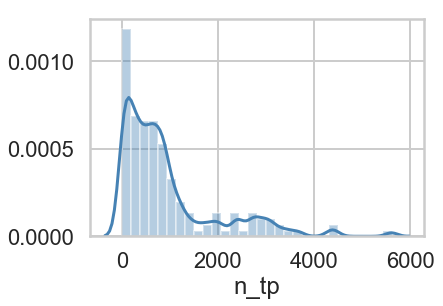

In [9]:
sns.distplot(net_data['n_tp'], bins=30, color='steelblue')

In [10]:
net_data.subj.nunique()

162

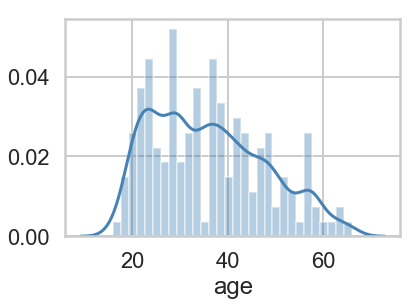

In [11]:
net_data['age'].replace(to_replace=0, value=None, inplace=True)
sns.distplot(net_data['age'].dropna(), bins=30, color='steelblue')
mean_age = net_data['age'].mean()

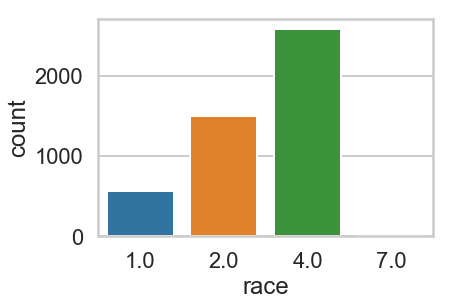

In [12]:
sns.countplot(data=net_data, x='race', )
mean_race = 4

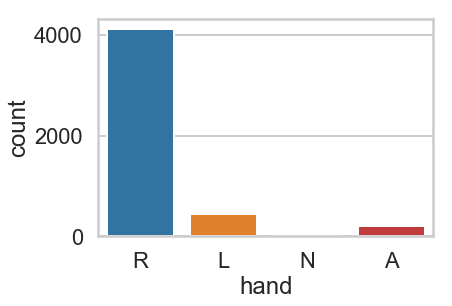

In [13]:
sns.countplot(data=net_data, x='hand', )
mean_hand = 'R'

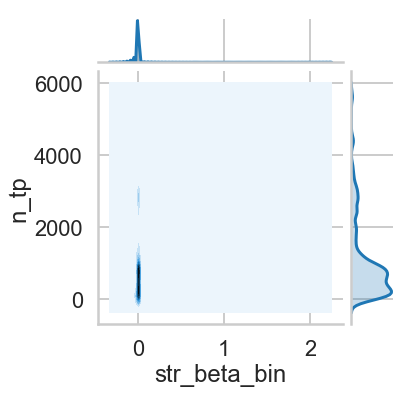

In [14]:
sns.jointplot(data=net_data, x='str_beta_bin', y='n_tp', kind='kde' )

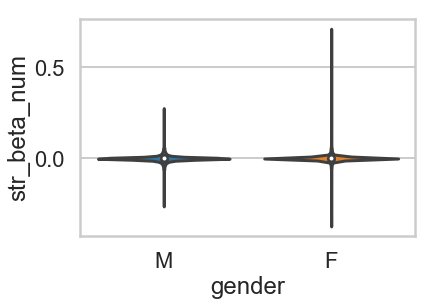

In [15]:
sns.violinplot(data=net_data, x='gender', y='str_beta_num', cut=True)

In [16]:
# add means for null values
net_data.loc[net_data['age'].isnull(), 'age'] = mean_age
net_data.loc[net_data['race'].isnull(), 'race'] = mean_race
net_data.loc[net_data['hand'].isnull(), 'hand'] = mean_hand

# same for node data
node_data.loc[node_data['age'].isnull(), 'age'] = mean_age
node_data.loc[node_data['race'].isnull(), 'race'] = mean_race
node_data.loc[node_data['hand'].isnull(), 'hand'] = mean_hand

In [17]:
# check for duplicates, these two numbers should match
print(net_data[['str_beta_bin','subj']].dropna().subj.nunique())
print(net_data.loc[net_data.band_measure == 'theta_iplv',['str_beta_bin','subj']].dropna().subj.count())

145
146


In [20]:
net_data.loc[net_data.subj == 'R1232N','n_tp'].unique()

array([328, 289])

In [47]:
# some subjects have ambidextrous and right handed answers in demographics, 
# take the one that is used in the net data (whatever they said first)
dems = ['race', 'hand', 'gender', 'age']
subjs = node_data['subj'].unique()
for s in subjs:
    if any(node_data.loc[node_data['subj'] == s, dems].nunique() > 1):
        correct_dems = net_data.loc[net_data.subj == s, dems]
        node_data.loc[node_data['subj'] == s, dems] = np.tile(correct_dems.iloc[0,:].values, 
                                                              (sum(node_data['subj'] == s),1))
node_data.drop(index=node_data.index[node_data.duplicated()], inplace=True)
node_data.info()

IndexError: single positional indexer is out-of-bounds

In [50]:
# drop nulls
cols = ['str_beta_bin','str_beta_num','str_beta_spr']

keep_subj = net_data.pivot_table(index='subj', columns=['fc_measure'],
                     values=['str_beta_bin','str_beta_num','str_beta_spr'], 
                                 aggfunc = lambda x: any(np.isnan(x))).any(axis=1)
keep_subj = keep_subj.index[[not x for x in keep_subj.values]]

net_data = net_data[[x in keep_subj for x in net_data.subj]]
node_data = node_data[[x in keep_subj for x in node_data.subj]]

In [51]:
net_data.subj.nunique()

143

## Effects on Network Measures

visualize how much spikes regularly change network strength.

In [52]:
# remove outliers 3 std
group_mean = net_data.groupby('band_measure').mean()
group_sd = net_data.groupby('band_measure').std()
bm = group_mean.index
col = group_mean.columns[1:-2]
for b in bm:
    for c in col:
        idx = (net_data['band_measure'] == b) & ((net_data.loc[:,c] > (group_mean.loc[b,c] + 3*group_sd.loc[b,c])) |
                                                 (net_data.loc[:,c] < (group_mean.loc[b,c] - 3*group_sd.loc[b,c])))
        net_data.loc[idx,c] = np.nan
net_data.head()

band_measure  n_tp  str_beta_bin  str_beta_num  str_beta_spr  \
1        alpha_aec   107     -0.001170     -0.003834     -0.000906   
2  alpha_aec_ortho   107      0.003289      0.001749     -0.000120   
3        alpha_coh   107     -0.002831     -0.001307     -0.000162   
4     alpha_im_coh   107     -0.002251     -0.001216     -0.000052   
5       alpha_iplv   107     -0.011551     -0.018571     -0.000731   

   ti_beta_bin  ti_beta_num  ti_beta_spr  str_soz_beta_bin  str_soz_beta_num  \
1    -0.003215     0.007433     0.001236         -0.002027         -0.003219   
2    -0.038618    -0.040827    -0.004130          0.008756          0.011889   
3     0.087585     0.122493    -0.000073         -0.006692         -0.005622   
4     0.007866     0.010105    -0.000839         -0.006423         -0.004927   
5     0.035004     0.052945     0.002363         -0.019025         -0.032505   

         ...          str_wm_beta_spr  str_gm_beta_bin  str_gm_beta_num  \
1        ...                -0.000686        -0.009536        -0.014797   
2        ...                 0.000131        -0.004099        -0.014693   
3        ...                -0.000051        -0.000563         0.005013   
4        ...                 0.000098        -0.002076         0.000317   
5        ...                -0.000905        -0.004416        -0.009796   

   str_gm_beta_spr    subj  hand   age  gender race  str_brid_beta_num  
1        -0.001593  R1170J     R  20.0       M  2.0                NaN  
2        -0.000284  R1170J     R  20.0       M  2.0                NaN  
3        -0.000229  R1170J     R  20.0       M  2.0                NaN  
4        -0.000271  R1170J     R  20.0       M  2.0                NaN  
5        -0.000323  R1170J     R  20.0       M  2.0                NaN  

[5 rows x 40 columns]

In [53]:
# save
# rename stuff to make it pretty
net_data.replace({'band':{'theta':'Theta', 'alpha':'Alpha','beta':'Beta', 'gamma':'Gamma',
                         'hg':'High Gamma', 'broadband':'LFP'}}, inplace=True)
net_data.rename(columns={'band':'Frequency Band', 'fc_measure':'Measure'}, inplace=True)
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_data_clean{detector}.csv')

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


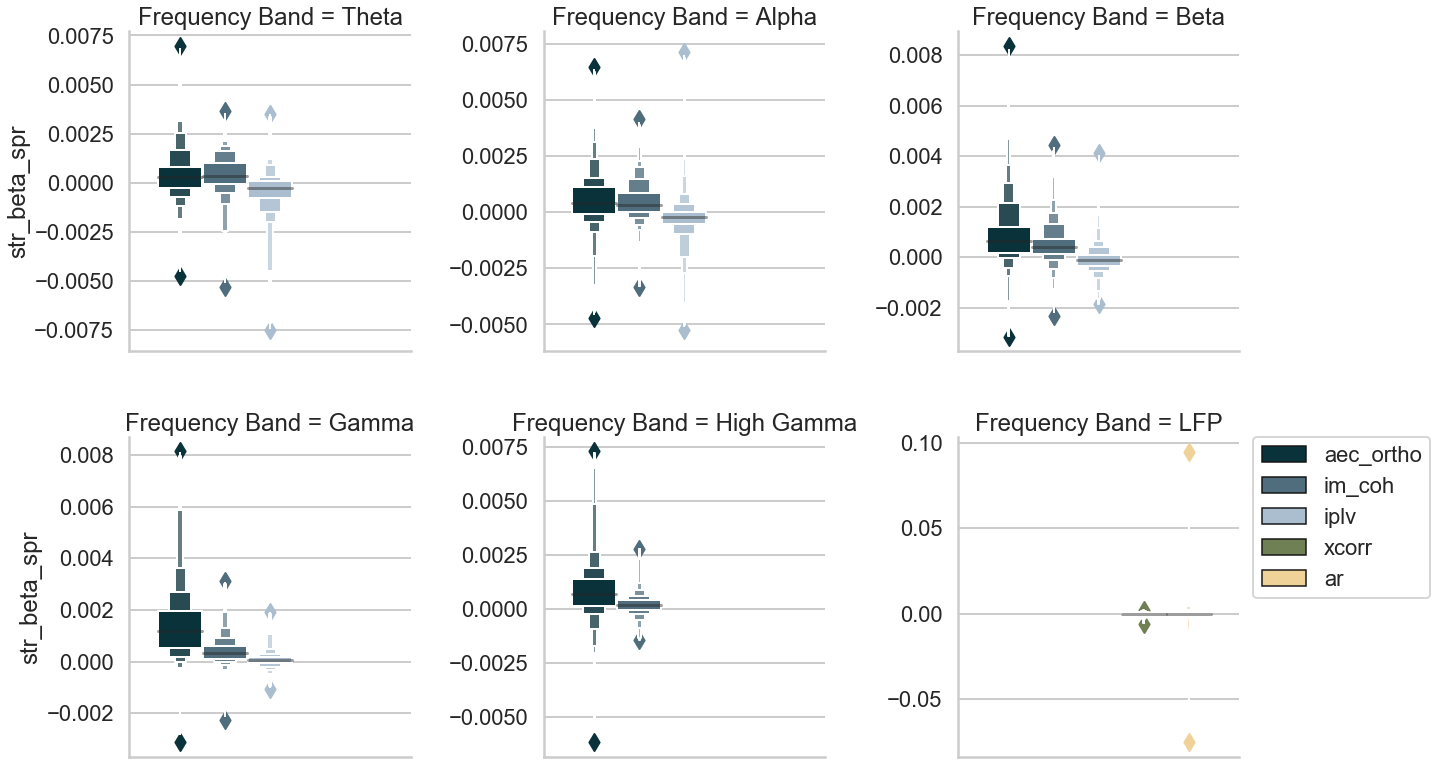

In [54]:
# parameters
supp_flag = True # if true, includes orthogonal AEC
yvar = 'spr'

if (not supp_flag):
    h_order = ['aec',  'coh', 'plv', 'xcorr', 'ar']
    supp_ext = ''
    # colors
    colors = ['#453947','#84476f', '#BB84C2', '#72874E', '#FED789']
    custom_palette = sns.set_palette(sns.color_palette(colors))
else:
    h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']
    supp_ext = '_supp'
    # color pallette
    colors = ['#023743',  '#476f84', '#A4BED5', '#72874E', '#FED789']

    
g = sns.FacetGrid(data=net_data, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, 
                 col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
g.map(sns.boxenplot, 'Frequency Band', 'str_beta_' + yvar, 'Measure', palette = sns.color_palette(colors), 
      hue_order=h_order)

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
for ax in g.axes:
    ax.axes.xaxis.set_visible(False)
if (supp_flag):  
    g.savefig(f"../img/net_{yvar}_str{detector}_vc.eps")
else:
    g.savefig(f"../img/net_{yvar}_str{detector}.eps")

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


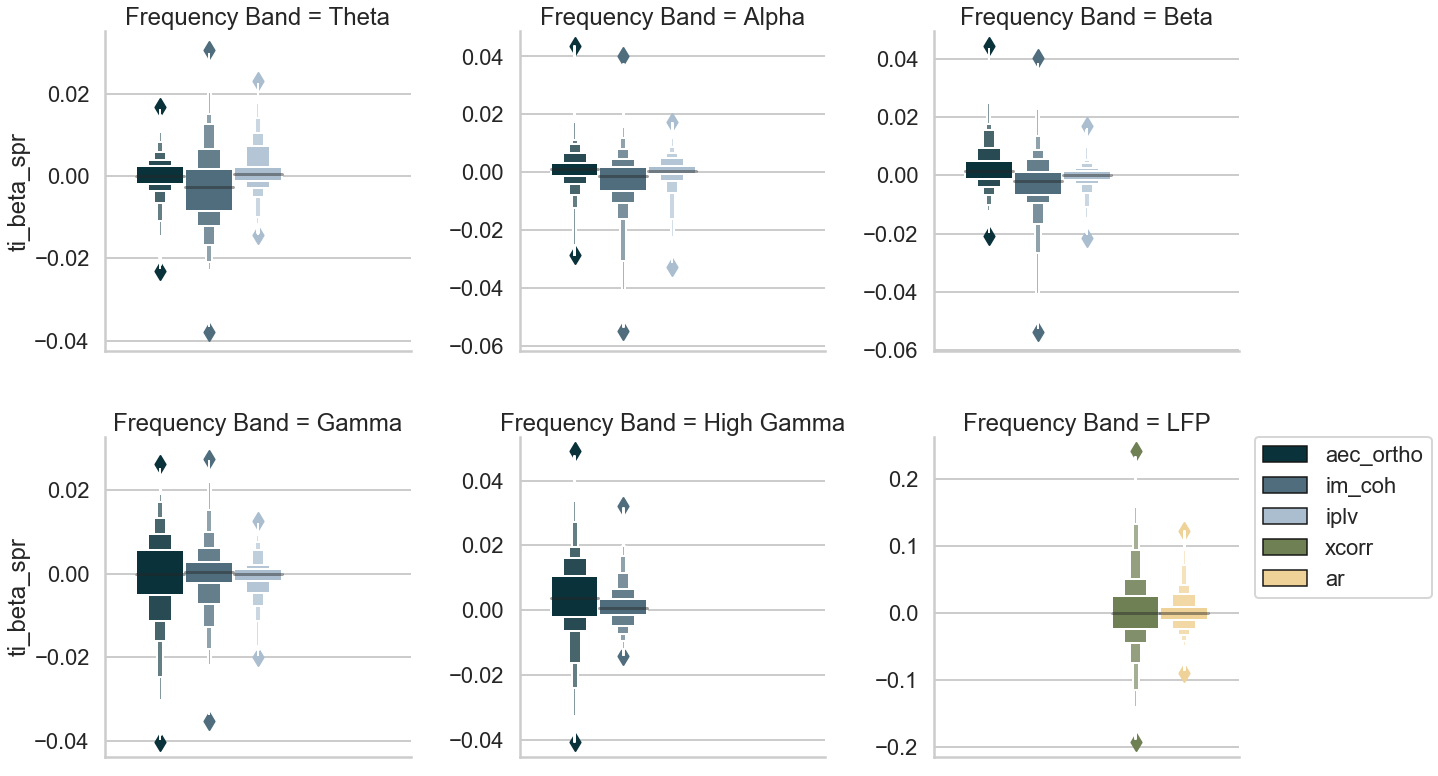

In [55]:
# parameters
supp_flag = True # if true, includes orthogonal AEC
yvar = 'spr'

if (not supp_flag):
    h_order = ['aec',  'coh', 'plv', 'xcorr', 'ar']
    supp_ext = ''
    # colors
    colors = ['#453947','#84476f', '#BB84C2', '#72874E', '#FED789']
    custom_palette = sns.set_palette(sns.color_palette(colors))
else:
    h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']
    supp_ext = '_supp'
    # color pallette
    colors = ['#023743',  '#476f84', '#A4BED5', '#72874E', '#FED789']

    
g = sns.FacetGrid(data=net_data, col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, 
                 col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
g.map(sns.boxenplot, 'Frequency Band', 'ti_beta_' + yvar, 'Measure', palette = sns.color_palette(colors), 
      hue_order=h_order)

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
for ax in g.axes:
    ax.axes.xaxis.set_visible(False)
if (supp_flag):  
    g.savefig(f"../img/net_{yvar}_ti{detector}_vc.eps")
else:
    g.savefig(f"../img/net_{yvar}_ti{detector}.eps")

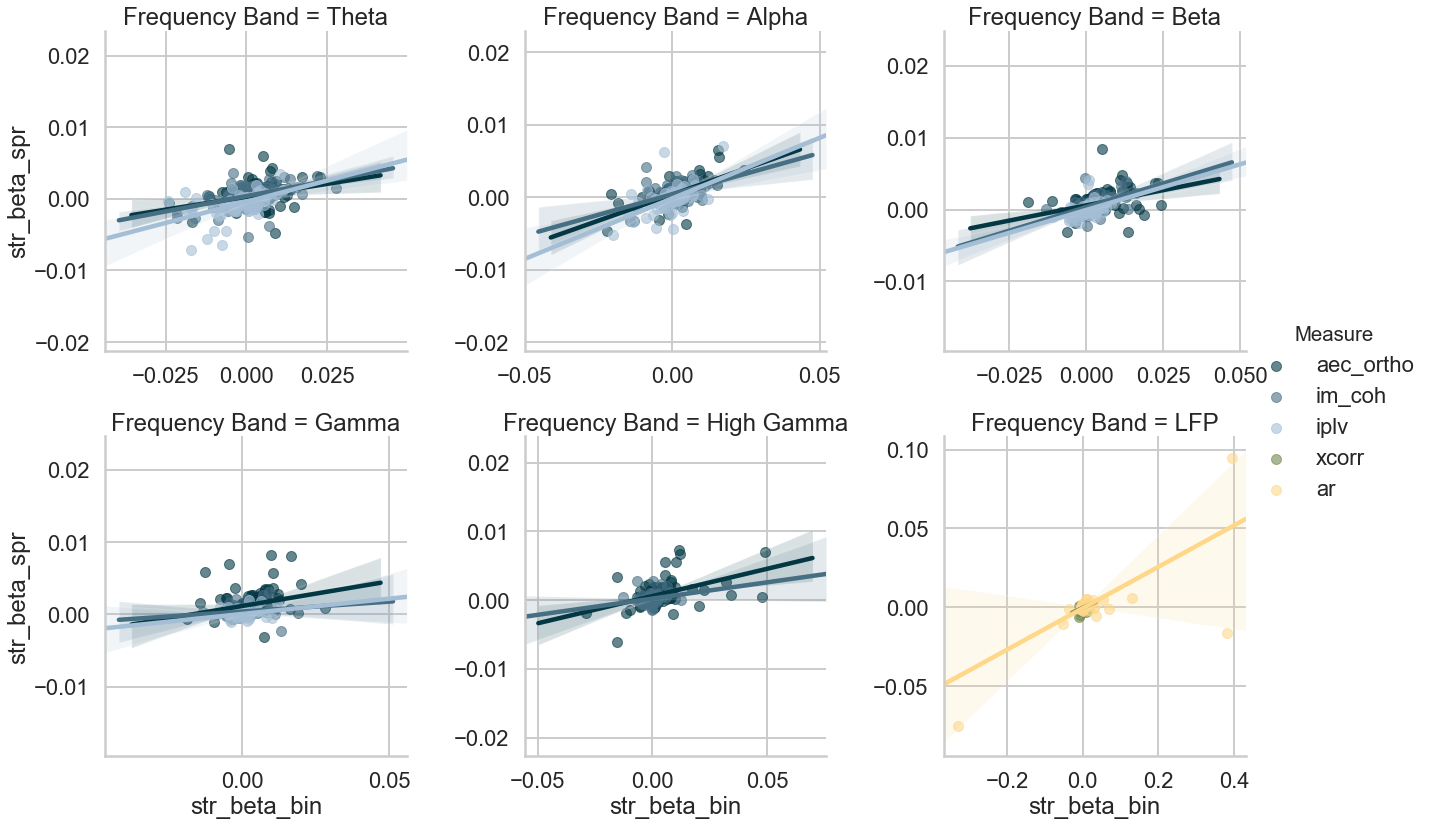

In [56]:
var1 = 'bin'
var2 = 'spr'
sns.lmplot(data=net_data, x='str_beta_' + var1, y='str_beta_' + var2, hue='Measure', col="Frequency Band", 
           col_wrap=3, height=6, sharex=False, sharey=False, 
           col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'],
           palette=sns.color_palette(colors), 
           scatter_kws={'s':100, 'alpha':.6}, 
           hue_order=h_order)
plt.savefig(f"../img/{var1}_{var2}.pdf")

Is this because of volume conduction?

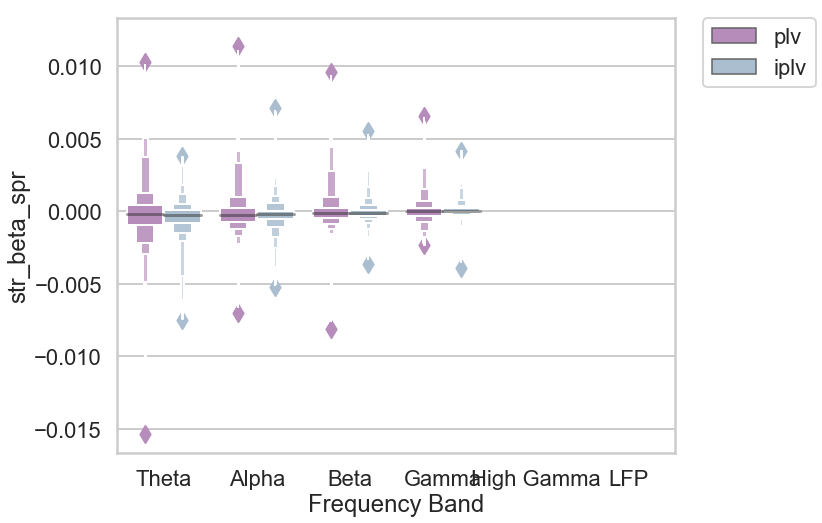

In [36]:

# parameters
y_var = 'spr'
m = 'plv'

if (m == 'coh'):
    h_order = ['coh', 'im_coh']
    # color pallette
    colors = ['#84476f', '#476f84']
elif (m=='aec'):
    h_order = ['aec', 'aec_ortho']
    colors = ['#453947', '#023732']
else:
    h_order = ['plv', 'iplv']
    colors = ['#BB84C2', '#A4BED5']
custom_palette = sns.set_palette(sns.color_palette(colors))

fig = plt.figure(figsize=(10,8))
sns.boxenplot( data=net_data[(net_data['Measure'] == h_order[0]) | (net_data['Measure'] == h_order[1])]
              , x="Frequency Band", y='str_beta_' + y_var, hue='Measure', 
            order=['Theta','Alpha','Beta','Gamma','High Gamma','LFP'], hue_order=h_order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim(-2,2)
plt.savefig(f"../img/volume_conduction_{y_var}_{m}{detector}.eps")


In [57]:
# initialize lists for later - need to keep trake of all predictors
null_data = pd.DataFrame(columns=['yvar', 'cors', 'type'])

y = []
label = []
rval = []
pval = []
ci_up = []
ci_lo = []


In [67]:
# get correlation matrix for all str effects
yvar = 'bin' 
net_data = net_data[(net_data['Measure'] != 'aec') & (net_data['Measure'] != 'coh') & (net_data['Measure'] != 'plv')]
net_data = net_data.assign(measure_band = net_data['Measure'] + '_' + net_data['Frequency Band'])
band_data = net_data.pivot_table(index = 'subj', columns='band_measure', 
                          values = ['str_beta_' + yvar]) # default agg func is mean
band_data.columns = [col[1] for col in band_data.columns]
cols = band_data.columns
cols = np.concatenate((cols[-3:].values, cols[:6].values, cols[8:-3].values, cols[6:8].values))
band_data = band_data[cols]
band_data.head()

theta_aec_ortho  theta_im_coh  theta_iplv  alpha_aec_ortho  \
subj                                                                 
R1001P         0.000523      0.000763    0.000817        -0.000180   
R1002P         0.001295      0.004785    0.002457        -0.000569   
R1003P        -0.000202      0.002789    0.001284        -0.000118   
R1004D              NaN           NaN    0.003072              NaN   
R1008J         0.006083      0.001252    0.001664        -0.000131   

        alpha_im_coh  alpha_iplv  beta_aec_ortho  beta_im_coh  beta_iplv  \
subj                                                                       
R1001P      0.000045   -0.000972        0.001077     0.000230  -0.000757   
R1002P      0.002074    0.000155        0.002119     0.001555  -0.001162   
R1003P      0.000807   -0.001237        0.000407     0.000425  -0.000754   
R1004D           NaN    0.017330             NaN          NaN        NaN   
R1008J      0.001739    0.001258        0.000752     0.000594  -0.000261   

        gamma_aec_ortho  gamma_im_coh  gamma_iplv  hg_aec_ortho  hg_im_coh  \
subj                                                                         
R1001P         0.000856      0.000375   -0.000064      0.000626   0.000574   
R1002P         0.004203      0.001425    0.000677      0.004770   0.001192   
R1003P         0.002247     -0.000215    0.000264      0.000077  -0.000405   
R1004D         0.023132           NaN         NaN     -0.015638   0.006422   
R1008J        -0.000092     -0.000896    0.000295     -0.000509  -0.001234   

        broadband_ar  broadband_xcorr  
subj                                   
R1001P      0.003431        -0.004424  
R1002P     -0.000553         0.003471  
R1003P      0.000710        -0.002121  
R1004D      0.002040         0.000201  
R1008J     -0.000328        -0.001104

In [68]:
meas_data = net_data.pivot_table(index = 'subj', columns='measure_band', 
                                 values = ['str_beta_' + yvar])
meas_data.columns = [col[1] for col in meas_data.columns]
cols = meas_data.columns
cols = np.concatenate((cols[4:-11].values, cols[0:4].values, cols[10:-5].values, cols[6:10].values, 
                       cols[14:15].values, cols[11:14].values, cols[15:16].values, cols[5:-10].values))
meas_data = meas_data[cols]
meas_data.head()

aec_ortho_Theta  aec_ortho_Alpha  aec_ortho_Beta  aec_ortho_Gamma  \
subj                                                                        
R1001P         0.000523        -0.000180        0.001077         0.000856   
R1002P         0.001295        -0.000569        0.002119         0.004203   
R1003P        -0.000202        -0.000118        0.000407         0.002247   
R1004D              NaN              NaN             NaN         0.023132   
R1008J         0.006083        -0.000131        0.000752        -0.000092   

        aec_ortho_High Gamma  im_coh_Theta  im_coh_Alpha  im_coh_Beta  \
subj                                                                    
R1001P              0.000626      0.000763      0.000045     0.000230   
R1002P              0.004770      0.004785      0.002074     0.001555   
R1003P              0.000077      0.002789      0.000807     0.000425   
R1004D             -0.015638           NaN           NaN          NaN   
R1008J             -0.000509      0.001252      0.001739     0.000594   

        im_coh_Gamma  im_coh_High Gamma  iplv_Theta  iplv_Alpha  iplv_Beta  \
subj                                                                         
R1001P      0.000375           0.000574    0.000817   -0.000972  -0.000757   
R1002P      0.001425           0.001192    0.002457    0.000155  -0.001162   
R1003P     -0.000215          -0.000405    0.001284   -0.001237  -0.000754   
R1004D           NaN           0.006422    0.003072    0.017330        NaN   
R1008J     -0.000896          -0.001234    0.001664    0.001258  -0.000261   

        iplv_Gamma  xcorr_LFP    ar_LFP  
subj                                     
R1001P   -0.000064  -0.004424  0.003431  
R1002P    0.000677   0.003471 -0.000553  
R1003P    0.000264  -0.002121  0.000710  
R1004D         NaN   0.000201  0.002040  
R1008J    0.000295  -0.001104 -0.000328

In [69]:
# ordered by subj corr map
sim_metric = 'corr' # correlation or euclidean distance
if sim_metric == 'corr':
    band_rsm = band_data.corr(method='spearman')
    meas_rsm = meas_data.corr(method='spearman')
    # remove diagonal
    band_rsm[band_rsm == 1] = np.nan
    meas_rsm[meas_rsm==1] = np.nan
else:
    band_rsm = euclidean_distances(band_data)
    meas_rsm = euclidean_distances(meas_data)


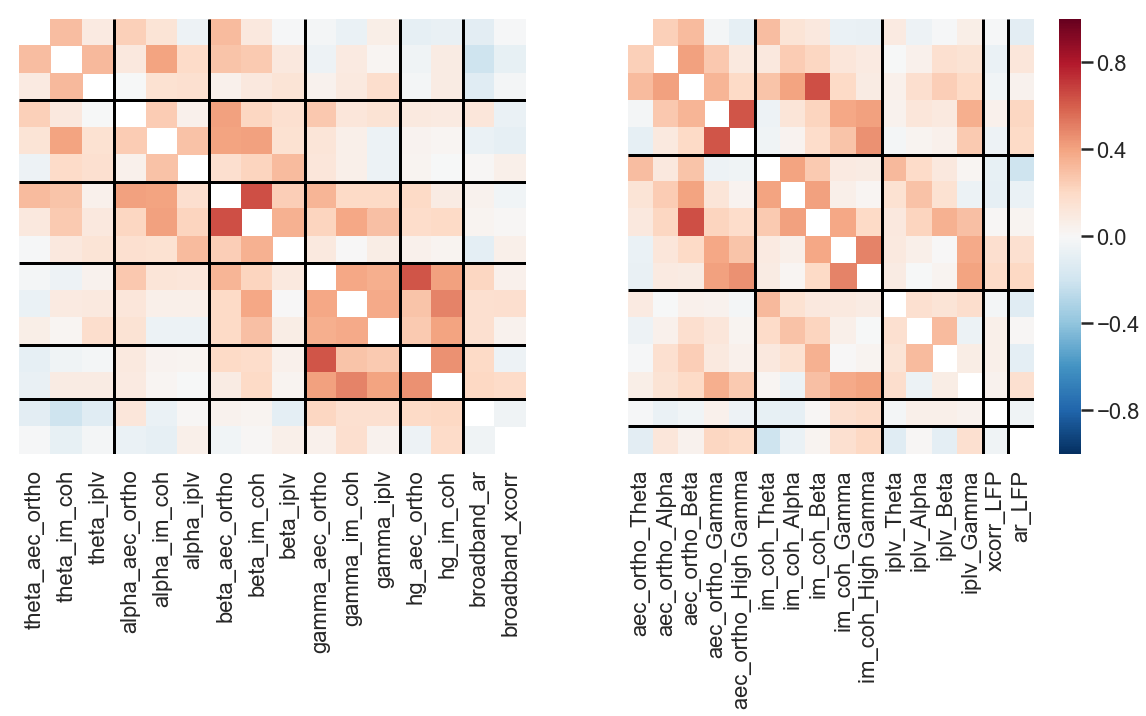

In [70]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
sns.heatmap(band_rsm, xticklabels=True, yticklabels=False, cmap ='RdBu_r',  cbar=False, ax=axes[0],
           vmin=-1, vmax=1)
axes[0].hlines([3,6,9,12,14], xmin=0, xmax=16)
axes[0].vlines([3,6,9,12,14],0,16)
sns.heatmap(meas_rsm, xticklabels=True, yticklabels=False, cmap='RdBu_r', cbar=True, ax=axes[1],
           vmin=-1, vmax=1)
axes[1].hlines([5,10,14,15],0,16)
axes[1].vlines([5,10,14,15],0,16)
plt.savefig(f'../img/band_meas_sim_{yvar}.pdf')

In [71]:
band_within = np.zeros(np.shape(band_rsm))
meas_within = np.zeros(np.shape(band_rsm))
group_within = np.zeros(np.shape(band_rsm))

band_cols = [x.split('_')[0] for x in band_rsm.columns]
meas_cols = [x.split('_')[0] for x in meas_rsm.columns]
band_rows = [x.split('_')[0] for x in band_rsm.index]
meas_rows = [x.split('_')[0] for x in meas_rsm.index]
for b in np.unique(band_rows):
    band_within[np.where([x == b for x in band_rows])[0][0]:(np.where([x == b for x in band_rows])[0][-1] + 1),
                np.where([x == b for x in band_cols])[0][0]:(np.where([x == b for x in band_cols])[0][-1] + 1)] = 1
for m in np.unique(meas_rows):
    meas_within[np.where([x == m for x in meas_rows])[0][0]:(np.where([x == m for x in meas_rows])[0][-1] + 1),
                np.where([x == m for x in meas_cols])[0][0]:(np.where([x == m for x in meas_cols])[0][-1] + 1)] = 1
    
# frequency bands
groups = [['theta','alpha', 'beta'],['gamma','hg']]
for g in groups:
    group_within[np.where([x in g for x in band_rows])[0][0]:(np.where([x in g for x in band_rows])[0][-1] + 1),
                np.where([x in g for x in band_cols])[0][0]:(np.where([x in g for x in band_cols])[0][-1] + 1)] = 1

    

In [72]:
# repeat for null values
def shuffle_label(data, n):
    subj = data['subj'].unique()
    nSubj = data['subj'].nunique()
    data['band_meas_new'] = data['band_measure']
    data['meas_band_new'] = data['measure_band']
    idx = np.arange(n)
    np.random.shuffle(idx)
    for i in range(nSubj):
        
        data.loc[data['subj'] == subj[i], 'band_meas_new'] = data.loc[data['subj'] == subj[i], 'band_meas_new'].values[idx]
        data.loc[data['subj'] == subj[i], 'meas_band_new'] = data.loc[data['subj'] == subj[i], 'meas_band_new'].values[idx]

nSim = 100
null_band_rsm = []
null_meas_rsm = []
null_tilt_rsm = []
for i in range(nSim):
    # shuffle
    order = net_data.groupby(['subj','band_measure', 'measure_band']).mean().reset_index()[['subj', 'band_measure', 'measure_band']]
    shuffle_label(order, order['band_measure'].nunique())

    curr = net_data[['subj', 'band_measure', 'measure_band', 'str_beta_' + yvar]]
    curr = curr.merge(order, how='right', on=['subj', 'band_measure', 'measure_band'])

    # format
    band_data = curr.pivot_table(index = 'subj', columns='band_meas_new', 
                          values = ['str_beta_' + yvar]) # default agg func is mean
    band_data.columns = [col[1] for col in band_data.columns]
    cols = band_data.columns
    cols = np.concatenate((cols[-3:].values, cols[:13].values))
    band_data = band_data[cols]


    # measure 
    #format
    meas_data = curr.pivot_table(index = 'subj', columns='meas_band_new', 
                                 values = ['str_beta_' + yvar])
    meas_data.columns = [col[1] for col in meas_data.columns]
    cols = meas_data.columns
    cols = np.concatenate((cols[4:-11].values, cols[0:4].values, cols[10:-5].values, cols[6:10].values, 
                       cols[14:15].values, cols[11:14].values, cols[15:16].values, cols[5:-10].values))
    meas_data = meas_data[cols]


    # get sim matrix
    tmp_band = band_data.corr(method='spearman')
    tmp_meas = meas_data.corr(method='spearman')
    tmp_band = tmp_band.values
    tmp_meas = tmp_meas.values

    # vectorize and correlate with mask
    [r,p] = sp.stats.pearsonr(band_within[np.triu_indices(np.size(band_cols),1)],
                 tmp_band[np.triu_indices(np.size(band_cols),1)])
    null_band_rsm.append(r)
    [r,p] = sp.stats.pearsonr(meas_within[np.triu_indices(np.size(band_cols),1)],
                 tmp_meas[np.triu_indices(np.size(band_cols),1)])
    null_meas_rsm.append(r)
    [r,p] = sp.stats.pearsonr(group_within[np.triu_indices(np.size(band_cols),1)],
                 tmp_band[np.triu_indices(np.size(band_cols),1)])
    null_tilt_rsm.append(r)

null_data = pd.merge(null_data, pd.DataFrame({'yvar':yvar, 
              'cors':list(itertools.chain.from_iterable([null_band_rsm,null_meas_rsm, null_tilt_rsm])),
              'type':list(itertools.chain.from_iterable([['band']*len(null_band_rsm), ['meas']*len(null_meas_rsm), ['tilt']*len(null_tilt_rsm)]))}),
               on=['yvar', 'cors', 'type'], how='outer')

In [73]:
# within band
band_test = band_rsm.values

[r,p] = sp.stats.pearsonr(band_within[np.triu_indices(np.size(band_cols),1)],
                 band_test[np.triu_indices(np.size(band_cols),1)])
print([r])

# get ci
r_z = np.arctanh(r)
se = 1/np.sqrt(np.size(band_test[np.triu_indices(np.size(band_cols),1)]) - 3)
alpha = 0.05
z = sp.stats.norm.ppf(1-alpha/2)
lo, hi = np.tanh(r_z-z*se), np.tanh(r_z+z*se)

y.append(yvar)
rval.append(r)
pval.append(p)
ci_up.append(hi)
ci_lo.append(lo)
label.append('band')


[0.35050364158406694]


In [74]:
# within measure
meas_test = meas_rsm.values
[r,p] = sp.stats.pearsonr(meas_within[np.triu_indices(np.size(band_cols),1)],
                 meas_test[np.triu_indices(np.size(band_cols),1)])
print([r])

# get ci
r_z = np.arctanh(r)
se = 1/np.sqrt(np.size(band_test[np.triu_indices(np.size(band_cols),1)]) - 3)
alpha = 0.05
z = sp.stats.norm.ppf(1-alpha/2)
lo, hi = np.tanh(r_z-z*se), np.tanh(r_z+z*se)

y.append(yvar)
rval.append(r)
pval.append(p)
ci_up.append(hi)
ci_lo.append(lo)
label.append('meas')

[0.25634983883741314]


In [75]:
# within tilt group
[r,p] = sp.stats.pearsonr(group_within[np.triu_indices(np.size(band_cols),1)],
                 band_test[np.triu_indices(np.size(band_cols),1)])
print([r])


# get ci
r_z = np.arctanh(r)
se = 1/np.sqrt(np.size(band_test[np.triu_indices(np.size(band_cols),1)]) - 3)
alpha = 0.05
z = sp.stats.norm.ppf(1-alpha/2)
lo, hi = np.tanh(r_z-z*se), np.tanh(r_z+z*se)

y.append(yvar)
rval.append(r)
pval.append(p)
ci_up.append(hi)
ci_lo.append(lo)
label.append('tilt')

[0.5792042758511294]


In [76]:
def grouped_barplot(df, cat,subcat, val , err,c,saveas):
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{} {}".format(subcat, gr), yerr=dfg[err].values, color=c[i])
    plt.xlabel(cat)
    plt.ylabel(val)
    plt.xticks(x, u)
    plt.legend()
    plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
    #plt.show()
    plt.savefig(saveas)

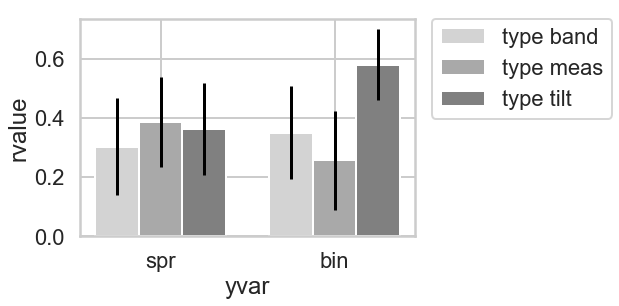

In [77]:
group_sim = pd.DataFrame({'yvar':y,'type':label,'rvalue':rval,'pvalue':pval, 
                          'err':(np.array(ci_up) - np.array(ci_lo))/2})
grouped_barplot(group_sim, 'yvar', 'type', 'rvalue', 'err', 
                ['lightgrey','darkgrey','grey','lightgrey','darkgrey','grey'], f"../img/band_meas_sim2.pdf")


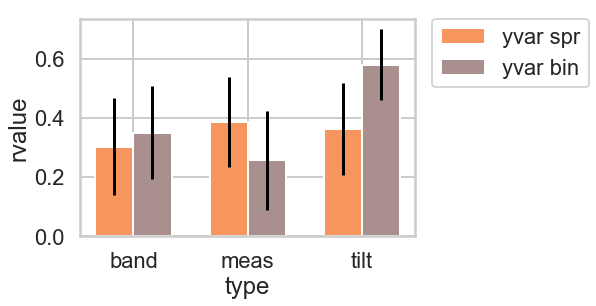

In [78]:
colors = ['#F6955E', '#A98F8E','#F6955E', '#A98F8E','#F6955E', '#A98F8E']
group_sim = pd.DataFrame({'yvar':y,'type':label,'rvalue':rval,'pvalue':pval, 
                          'err':(np.array(ci_up) - np.array(ci_lo))/2})
grouped_barplot(group_sim, 'type', 'yvar', 'rvalue', 'err',colors,f"../img/band_meas_sim.pdf" )


0
0
0
0
2
0


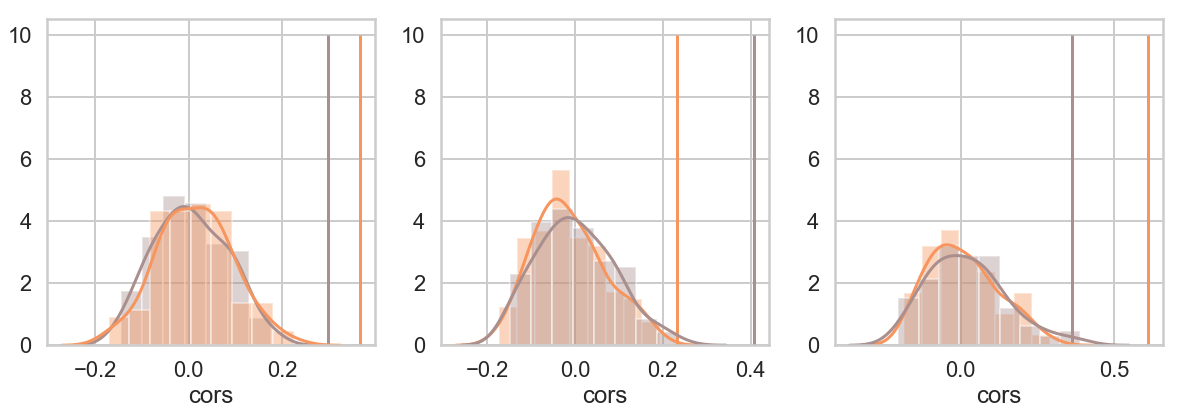

In [59]:
# plot null data
fig, ax = plt.subplots(1,3, figsize=(20,6))
print(sum(null_data.loc[(null_data['yvar']=='spr') & (null_data['type']=='band'), 'cors'].values > 
    group_sim.loc[(group_sim['yvar']=='spr') & (group_sim['type'] == 'band'),'rvalue'].values))
print(sum(null_data.loc[(null_data['yvar']=='bin') & (null_data['type']=='band'), 'cors'].values > 
    group_sim.loc[(group_sim['yvar']=='bin') & (group_sim['type'] == 'band'),'rvalue'].values))
sns.distplot(null_data.loc[(null_data['yvar']=='spr') & (null_data['type']=='band'), 'cors'], color= '#A98F8E', ax=ax[0])
sns.distplot(null_data.loc[(null_data['yvar']=='bin') & (null_data['type']=='band'),'cors'],color='#F6955E',ax=ax[0])
ax[0].vlines(group_sim.loc[(group_sim['yvar']=='spr') & (group_sim['type'] == 'band'),'rvalue'], 0, 10, color= '#A98F8E')
ax[0].vlines(group_sim.loc[(group_sim['yvar']=='bin') & (group_sim['type'] == 'band'), 'rvalue'], 0, 10, color='#F6955E')

print(sum(null_data.loc[(null_data['yvar']=='spr') & (null_data['type']=='meas'), 'cors'].values > 
    group_sim.loc[(group_sim['yvar']=='spr') & (group_sim['type'] == 'meas'),'rvalue'].values))
print(sum(null_data.loc[(null_data['yvar']=='bin') & (null_data['type']=='meas'), 'cors'].values > 
    group_sim.loc[(group_sim['yvar']=='bin') & (group_sim['type'] == 'meas'),'rvalue'].values))
sns.distplot(null_data.loc[(null_data['yvar']=='bin') & (null_data['type']=='meas'), 'cors'], color='#F6955E', ax=ax[1])
sns.distplot(null_data.loc[(null_data['yvar']=='spr') & (null_data['type']=='meas'),'cors'],color= '#A98F8E',ax=ax[1])
ax[1].vlines(group_sim.loc[(group_sim['yvar']=='bin') & (group_sim['type'] == 'meas'),'rvalue'], 0, 10, color='#F6955E')
ax[1].vlines(group_sim.loc[(group_sim['yvar']=='spr') & (group_sim['type'] == 'meas'), 'rvalue'], 0,10, color= '#A98F8E')

print(sum(null_data.loc[(null_data['yvar']=='spr') & (null_data['type']=='tilt'), 'cors'].values > 
    group_sim.loc[(group_sim['yvar']=='spr') & (group_sim['type'] == 'tilt'),'rvalue'].values))
print(sum(null_data.loc[(null_data['yvar']=='bin') & (null_data['type']=='tilt'), 'cors'].values > 
    group_sim.loc[(group_sim['yvar']=='bin') & (group_sim['type'] == 'tilt'),'rvalue'].values))
sns.distplot(null_data.loc[(null_data['yvar']=='bin') & (null_data['type']=='tilt'), 'cors'], color='#F6955E', ax=ax[2])
sns.distplot(null_data.loc[(null_data['yvar']=='spr') & (null_data['type']=='tilt'),'cors'],color= '#A98F8E',ax=ax[2])
ax[2].vlines(group_sim.loc[(group_sim['yvar']=='bin') & (group_sim['type'] == 'tilt'),'rvalue'], 0, 10, color='#F6955E')
ax[2].vlines(group_sim.loc[(group_sim['yvar']=='spr') & (group_sim['type'] == 'tilt'), 'rvalue'], 0,10, color= '#A98F8E')
plt.savefig(f'../img/perm_test_sim.pdf')

Is it different within or outside of the SOZ?

In [79]:
# add difference for plotting
net_data = net_data.assign(soz_diff_num = net_data['str_soz_beta_num'] - net_data['str_not_soz_beta_num'], 
                           soz_diff_bin = net_data['str_soz_beta_bin'] - net_data['str_not_soz_beta_bin'],
                           soz_diff_spr = net_data['str_soz_beta_spr'] - net_data['str_not_soz_beta_spr'])

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


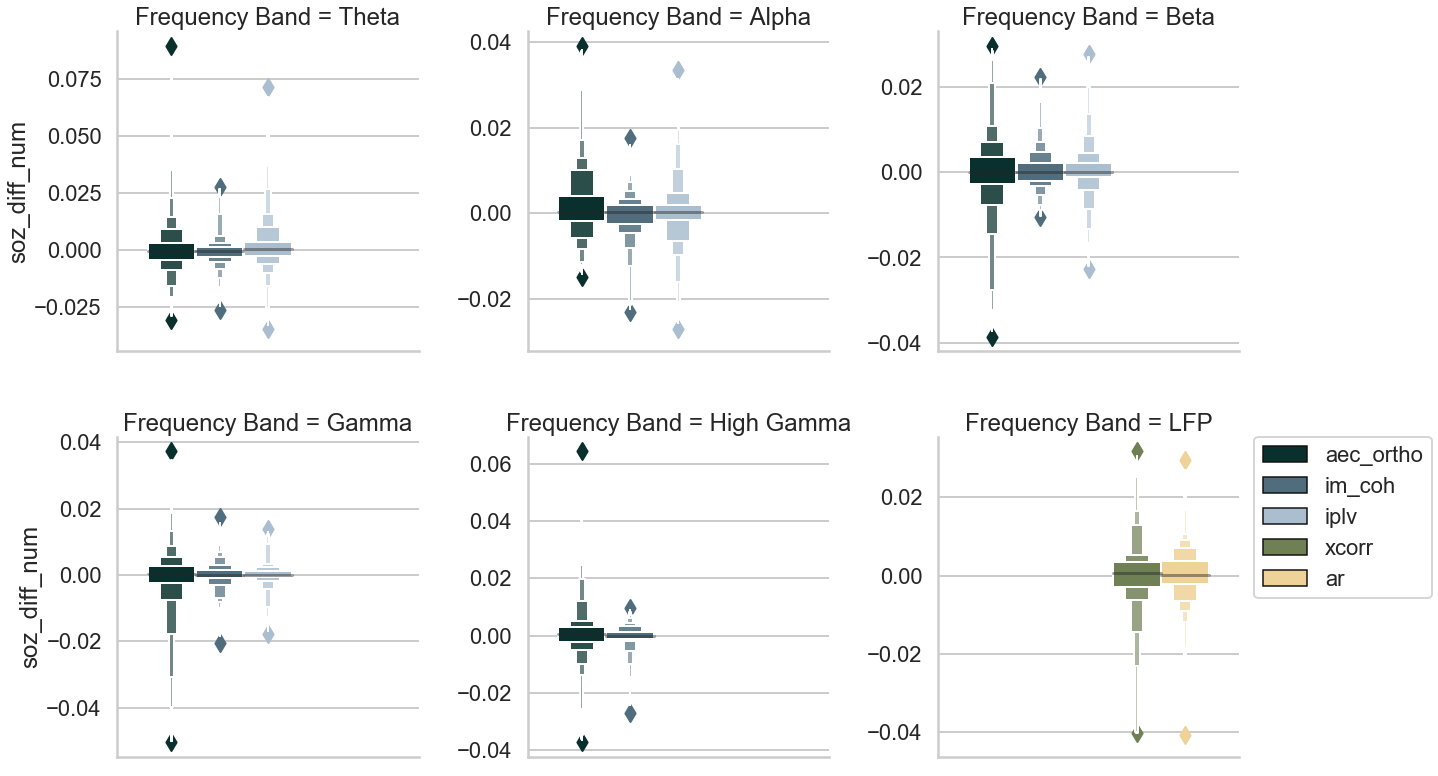

In [80]:
yvar = 'num'

colors = ['#023732', '#476f84', '#a4bed5', '#72874e', '#fed789']
h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']

g = sns.FacetGrid(data=net_data, col='Frequency Band', col_wrap=3, sharex=False, sharey=False, height=6,
                 col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
g.map(sns.boxenplot, "Frequency Band", "soz_diff_" + yvar, "Measure",
             hue_order = h_order,  palette=sns.color_palette(colors))
g.axes[5].legend(bbox_to_anchor=(1.05,1), loc=2,borderaxespad=0.)
for ax in g.axes:
    ax.axes.xaxis.set_visible(False)

g.savefig(f"../img/net_soz_{yvar}{detector}.eps")

In [81]:
# save
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_soz_data_clean{detector}.csv')

Repeat for spikes

In [82]:
# add difference for plotting
net_data = net_data.assign(spike_diff_num = net_data['str_spike_beta_num'] - net_data['str_not_spike_beta_num'], 
                           spike_diff_bin = net_data['str_spike_beta_bin'] - net_data['str_not_spike_beta_bin'],
                          spike_diff_spr = net_data['str_spike_beta_spr'] - net_data['str_not_spike_beta_spr'])

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


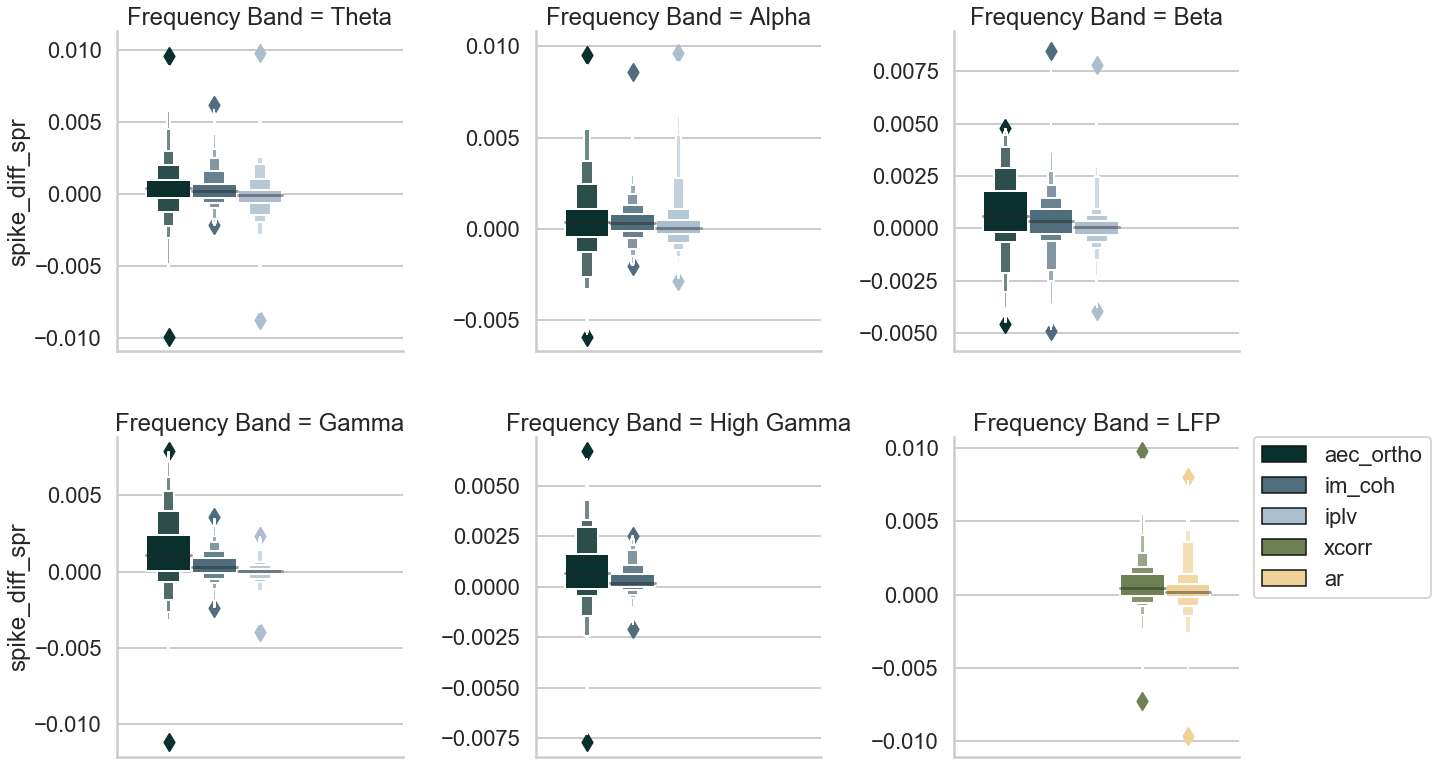

In [83]:
yvar = 'spr'

colors = ['#023732', '#476f84', '#a4bed5', '#72874e', '#fed789']
h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']

g=sns.FacetGrid(data=net_data, col="Frequency Band", col_wrap=3, col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'],
                sharex=False, sharey=False, height=6)
g.map(sns.boxenplot, "Frequency Band", "spike_diff_" + yvar, "Measure",
             hue_order = h_order, palette=sns.color_palette(colors))
g.axes[5].legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
for a in g.axes:
    a.axes.xaxis.set_visible(False)
g.savefig(f"../img/net_spike_{yvar}{detector}.eps")

In [84]:
# save
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_spike_data_clean{detector}.csv')

## Which explains more variance? Coverage, or individual?

In [70]:
# remove outliers 3 std for node data
group_mean = node_data.groupby(['band_measure', 'subj']).mean()
group_sd = node_data.groupby(['band_measure', 'subj']).std()*3
bm = group_mean.index
col = group_mean.columns[1:-2]
for b in bm:
    for c in col:
        idx = (node_data['band_measure'] == b[0]) & (node_data['subj'] == b[1]) & ((node_data.loc[:,c] > (group_mean.loc[b,c] + group_sd.loc[b,c])) | 
        node_data.loc[:,c] < (group_mean.loc[b,c] - group_sd.loc[b,c]))
        node_data.loc[idx,c] = np.nan
node_data.head()

elec     band_measure  n_tp  elec_spike  elec_in_soz  elec_in_ict  \
1   G1        alpha_aec   480    0.022917          0.0          0.0   
2   G1  alpha_aec_ortho   480    0.022917          0.0          0.0   
3   G1        alpha_coh   480    0.022917          0.0          0.0   
4   G1     alpha_im_coh   480    0.022917          0.0          0.0   
5   G1       alpha_iplv   480    0.022917          0.0          0.0   

   ti_beta_bin  ti_beta_num  ti_beta_spr  str_beta_spr ...        x        y  \
1    -0.009000    -0.000398    -0.008684      0.003535 ... -46.1038  19.0348   
2     0.027994     0.000747     0.011457     -0.000217 ... -46.1038  19.0348   
3    -0.003589    -0.001584    -0.006819      0.003071 ... -46.1038  19.0348   
4    -0.042537    -0.014506    -0.018886      0.000851 ... -46.1038  19.0348   
5    -0.000988    -0.006615     0.002825      0.000585 ... -46.1038  19.0348   

           z type    subj  hand  age  gender race  wm  
1 -44.942917    G  R1284N     L  NaN       F  1.0 NaN  
2 -44.942917    G  R1284N     L  NaN       F  1.0 NaN  
3 -44.942917    G  R1284N     L  NaN       F  1.0 NaN  
4 -44.942917    G  R1284N     L  NaN       F  1.0 NaN  
5 -44.942917    G  R1284N     L  NaN       F  1.0 NaN  

[5 rows x 25 columns]

In [71]:
# get correlation matrix for all str effects
# thi subj has duplicates...unclear why
node_data = node_data[node_data['subj'] != 'R1232N']
sim_data = node_data[['subj', 'region', 'str_beta_bin', 'str_beta_num', 'str_beta_spr', 'band_measure']]
sim_data = sim_data.assign(unique_id = sim_data['subj'] + '_' + sim_data['region'], 
                           reg_id = sim_data['region'] + '_' + sim_data['subj'])
subj_data = sim_data.pivot_table(index = 'unique_id', columns='band_measure', 
                          values = ['str_beta_bin', 'str_beta_num', 'str_beta_spr']) # default agg func is mean
subj_data.head()

str_beta_bin                                         \
band_measure               alpha_aec alpha_aec_ortho alpha_coh alpha_im_coh   
unique_id                                                                     
R1001P_fusiform            -0.002525       -0.002060 -0.000574    -0.000482   
R1001P_inferiortemporal    -0.002935       -0.002855  0.000067    -0.000069   
R1001P_lateraloccipital    -0.002296       -0.001429 -0.000732    -0.001176   
R1001P_lingual             -0.004350       -0.001302 -0.001229    -0.001270   
R1001P_middletemporal      -0.001627       -0.002295 -0.000385    -0.000269   

                                                                       \
band_measure            alpha_iplv alpha_plv  beta_aec beta_aec_ortho   
unique_id                                                               
R1001P_fusiform          -0.000837 -0.000305  0.002808       0.000913   
R1001P_inferiortemporal  -0.000599 -0.000344 -0.000039      -0.000018   
R1001P_lateraloccipital  -0.003465 -0.002843  0.001363       0.001536   
R1001P_lingual           -0.000434 -0.000792  0.000378       0.000531   
R1001P_middletemporal    -0.002245 -0.000704 -0.000239      -0.002384   

                                                 ...    str_beta_spr  \
band_measure             beta_coh beta_im_coh    ...          hg_aec   
unique_id                                        ...                   
R1001P_fusiform          0.000739    0.000190    ...        0.000404   
R1001P_inferiortemporal -0.001398   -0.001075    ...        0.000300   
R1001P_lateraloccipital -0.000974   -0.001035    ...       -0.000022   
R1001P_lingual          -0.002363   -0.001691    ...        0.000729   
R1001P_middletemporal    0.001682    0.001234    ...        0.000952   

                                                                    \
band_measure            hg_aec_ortho    hg_coh hg_im_coh theta_aec   
unique_id                                                            
R1001P_fusiform             0.000144  0.000266  0.000062 -0.000178   
R1001P_inferiortemporal    -0.000029  0.000106 -0.000077  0.001601   
R1001P_lateraloccipital    -0.000067 -0.000108 -0.000058 -0.001511   
R1001P_lingual              0.000819  0.000809  0.000652  0.001859   
R1001P_middletemporal       0.000706  0.000954  0.000569  0.001692   

                                                                           \
band_measure            theta_aec_ortho theta_coh theta_im_coh theta_iplv   
unique_id                                                                   
R1001P_fusiform               -0.000263  0.001439     0.000726  -0.000634   
R1001P_inferiortemporal        0.000141  0.001221     0.000565  -0.000358   
R1001P_lateraloccipital       -0.001176  0.000753     0.000497  -0.000876   
R1001P_lingual                 0.001409  0.002080     0.001349  -0.000224   
R1001P_middletemporal          0.001930  0.000978     0.000571  -0.000408   

                                   
band_measure            theta_plv  
unique_id                          
R1001P_fusiform          0.000041  
R1001P_inferiortemporal -0.000741  
R1001P_lateraloccipital -0.000072  
R1001P_lingual           0.000438  
R1001P_middletemporal   -0.000689  

[5 rows x 90 columns]

In [72]:
# get correlation matrix for all str effects
reg_data = sim_data.pivot_table(index = 'reg_id', columns='band_measure', 
                          values = ['str_beta_bin', 'str_beta_num', 'str_beta_spr']) # default agg func is mean
reg_data.head()

str_beta_bin                                         \
band_measure       alpha_aec alpha_aec_ortho alpha_coh alpha_im_coh   
reg_id                                                                
bankssts_R1008J     0.004012        0.000718  0.006418     0.004330   
bankssts_R1009W     0.006340        0.000975  0.001528     0.001677   
bankssts_R1014D    -0.005559        0.006178 -0.024950    -0.011233   
bankssts_R1019J    -0.000193        0.000991  0.000842     0.000462   
bankssts_R1022J     0.002767        0.001633  0.000283     0.000408   

                                                                         \
band_measure    alpha_iplv alpha_plv  beta_aec beta_aec_ortho  beta_coh   
reg_id                                                                    
bankssts_R1008J   0.004610  0.004590 -0.000383       0.000522  0.001345   
bankssts_R1009W   0.011697  0.011880 -0.007243      -0.008472 -0.000783   
bankssts_R1014D   0.000913 -0.006086  0.012066       0.021330 -0.010065   
bankssts_R1019J   0.000686  0.001496  0.000228      -0.000044  0.000497   
bankssts_R1022J   0.000916  0.001790 -0.001169      -0.000479  0.001686   

                               ...    str_beta_spr                         \
band_measure    beta_im_coh    ...          hg_aec hg_aec_ortho    hg_coh   
reg_id                         ...                                          
bankssts_R1008J    0.001276    ...        0.000215     0.000057  0.000027   
bankssts_R1009W    0.001972    ...        0.001034     0.000239  0.000256   
bankssts_R1014D   -0.002758    ...        0.009262     0.003567 -0.011489   
bankssts_R1019J    0.000381    ...        0.000003    -0.000039 -0.000034   
bankssts_R1022J    0.001283    ...        0.000228     0.000162  0.000209   

                                                                            \
band_measure    hg_im_coh theta_aec theta_aec_ortho theta_coh theta_im_coh   
reg_id                                                                       
bankssts_R1008J  0.000120 -0.000899       -0.000734  0.000863     0.000319   
bankssts_R1009W -0.000371  0.015627        0.006705  0.006046     0.003866   
bankssts_R1014D -0.002100  0.004694        0.003606 -0.008951    -0.007249   
bankssts_R1019J -0.000047 -0.000013        0.000130 -0.000028    -0.000021   
bankssts_R1022J  0.000113 -0.000414        0.000271  0.000211     0.000241   

                                      
band_measure    theta_iplv theta_plv  
reg_id                                
bankssts_R1008J  -0.000296 -0.001121  
bankssts_R1009W  -0.000053 -0.003243  
bankssts_R1014D  -0.002792 -0.006690  
bankssts_R1019J  -0.000097 -0.000121  
bankssts_R1022J  -0.000611 -0.000593  

[5 rows x 90 columns]

In [73]:
# ordered by subj corr map
sim_metric = 'corr' # correlation or euclidean distance
if sim_metric == 'corr':
    rsm = subj_data.T.corr(method="spearman")
    reg_rsm = reg_data.T.corr(method="spearman")
else:
    rsm = euclidean_distances(subj_data)
    reg_rsm = euclidean_distances(reg_data)

In [74]:
np.shape(rsm)

(2260, 2260)

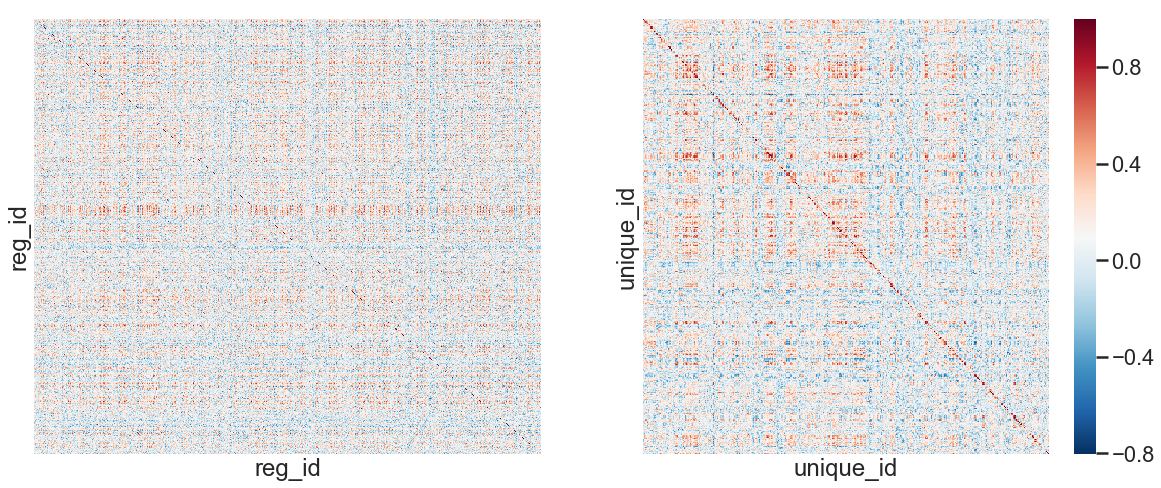

In [75]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
sns.heatmap(reg_rsm, xticklabels=False, yticklabels=False, cmap = 'RdBu_r',  cbar=False, ax=axes[0])
sns.heatmap(rsm, xticklabels=False, yticklabels=False, cmap='RdBu_r', cbar=True, ax=axes[1])
plt.savefig('../img/subj_sim.png')

In [76]:
subj_within = np.zeros(np.shape(rsm))
reg_within = np.zeros(np.shape(rsm))

reg_cols = [x.split('_')[0] for x in reg_rsm.columns]
subj_cols = [x.split('_')[0] for x in rsm.columns]
reg_rows = [x.split('_')[0] for x in reg_rsm.index]
subj_rows = [x.split('_')[0] for x in rsm.index]
for s in np.unique(subj_rows):
    subj_within[np.where([x == s for x in subj_rows])[0][0]:(np.where([x == s for x in subj_rows])[0][-1] + 1),
                np.where([x == s for x in subj_cols])[0][0]:(np.where([x == s for x in subj_cols])[0][-1] + 1)] = 1
for r in np.unique(reg_rows):
    reg_within[np.where([x == r for x in reg_rows])[0][0]:(np.where([x == r for x in reg_rows])[0][-1] + 1),
                np.where([x == r for x in reg_cols])[0][0]:(np.where([x == r for x in reg_cols])[0][-1] + 1)] = 1

    

In [77]:
# within subj
rval = []
pval = []
label = []
ci_lo = []
ci_hi = []

subj_test = rsm.as_matrix()
x = subj_within[np.triu_indices(np.size(subj_cols),1)]
y = subj_test[np.triu_indices(np.size(subj_cols),1)]
x = x[[not i for i in np.isnan(y)]]
y = y[[not i for i in np.isnan(y)]]
[r,p] = sp.stats.pearsonr(x,y)
print([r,p*2])

r_z = np.arctanh(r)
se = 1/np.sqrt(np.size(x) - 3)
alpha = 0.05
z = sp.stats.norm.ppf(1-alpha/2)
lo, hi = np.tanh(r_z-z*se), np.tanh(r_z+z*se)

ci_hi.append(hi)
ci_lo.append(lo)
rval.append(r)
pval.append(p)
label.append('subj')

/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


[0.126554068679819, 0.0]


In [78]:
# within reg
reg_test = reg_rsm.as_matrix()
x = reg_within[np.triu_indices(np.size(reg_cols),1)]
y = reg_test[np.triu_indices(np.size(reg_cols),1)]
x = x[[not i for i in np.isnan(y)]]
y = y[[not i for i in np.isnan(y)]]
[r,p] = sp.stats.pearsonr(x,y)
print([r,p*2]) #adding MC correction

r_z = np.arctanh(r)
se = 1/np.sqrt(np.size(x) - 3)
alpha = 0.05
z = sp.stats.norm.ppf(1-alpha/2)
lo, hi = np.tanh(r_z-z*se), np.tanh(r_z+z*se)

ci_lo.append(lo)
ci_hi.append(hi)
rval.append(r)
pval.append(p)
label.append('reg')

/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


[0.0024744964325770624, 0.00015402313473161035]


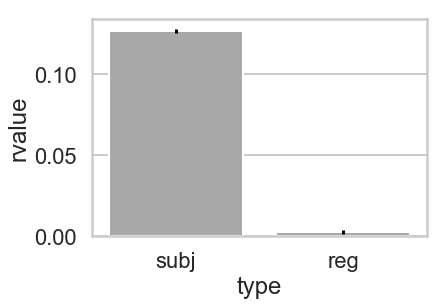

In [79]:
group_sim = pd.DataFrame({'type':label,'rvalue':(rval),'pvalue':pval, 
                          'ci':((np.array(ci_hi) - np.array(ci_lo))/2)})
sns.barplot(data=group_sim,x='type',y='rvalue',yerr=group_sim['ci'], color='darkgrey')
plt.savefig(f"../img/subj_reg_sim.pdf")

In [80]:
np.size(x)

2552655

## Effects on Node Measures

relationship between the number of spikes seen in that node, and the beta value

/Users/stiso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


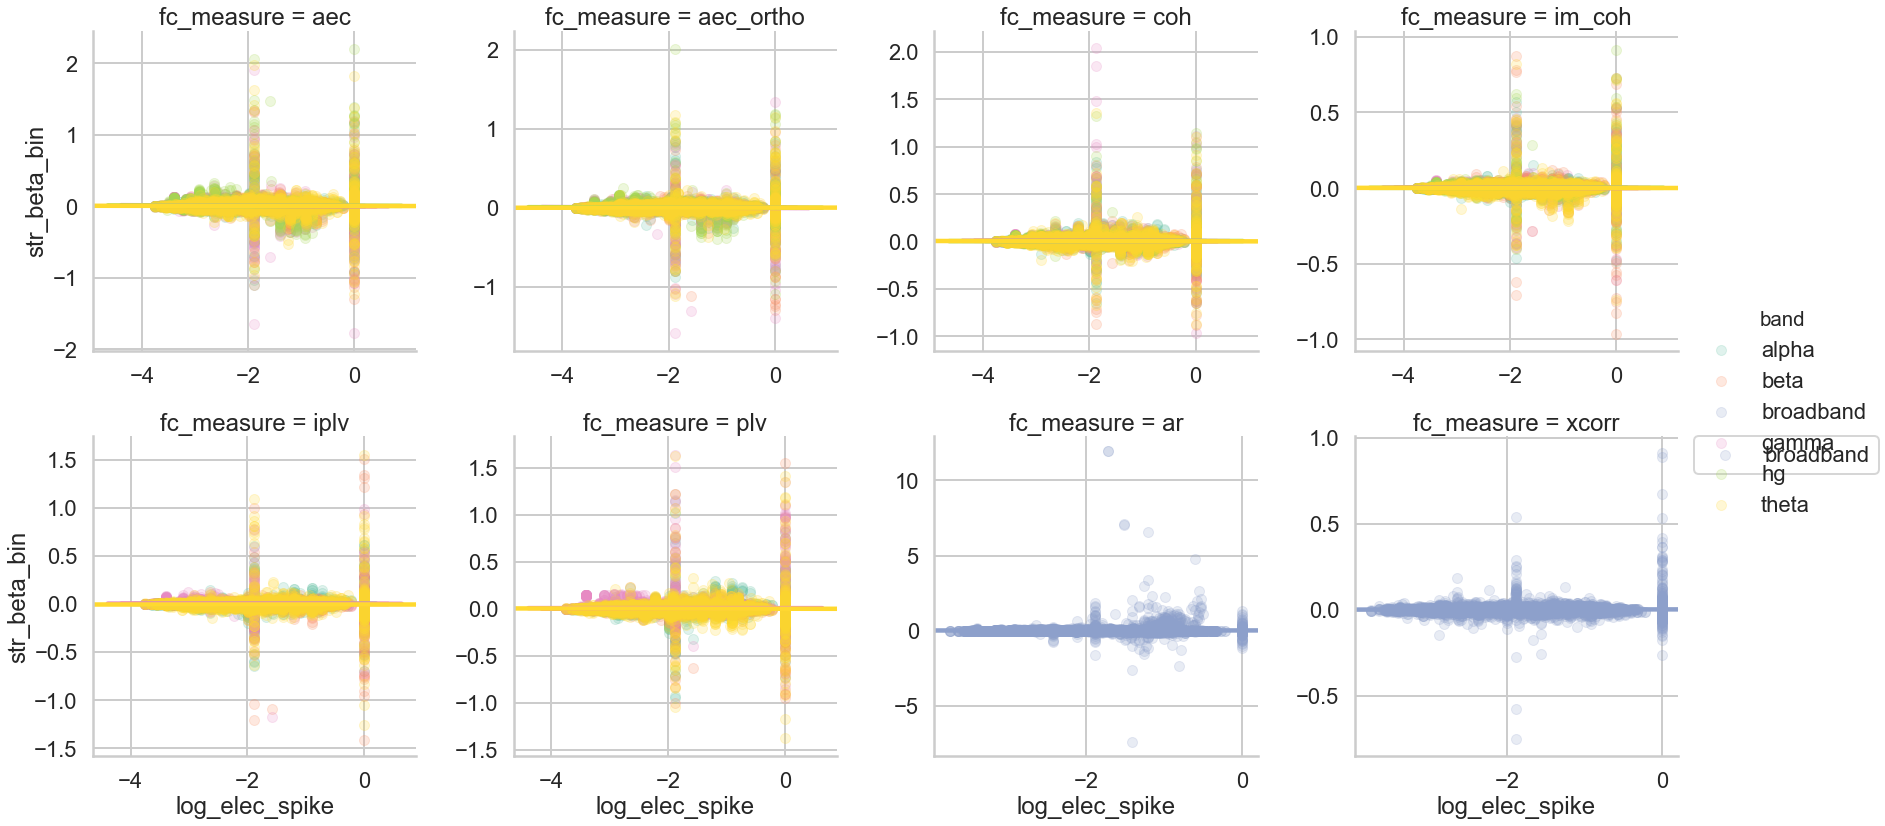

In [81]:
# add log transform
log_spike = np.zeros(np.shape(node_data['elec_spike']))
log_spike[[node_data['elec_spike'] != 0]] = np.log10(node_data['elec_spike'][node_data['elec_spike'] != 0])
node_data['log_elec_spike'] = log_spike

#color pallette
colors = ['#5b6c88', '#f0eee2']
custom_palette = sns.set_palette('Set2')

#plt.figure(figsize=(40,20))
sns.lmplot(data=node_data, x='log_elec_spike', y='str_beta_bin', hue='band', col="fc_measure", 
           col_wrap=4, height=6, sharex=False, sharey=False, scatter_kws={'s':100, 'alpha':.2})

plt.legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-2,2)
    

## Check for differences based on coverage

D    63
M    35
G    14
Name: contacts, dtype: int64

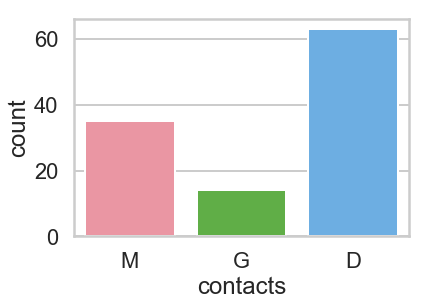

In [144]:
# check for strip grid difference
elec_type = node_data.groupby('subj').type.unique().reset_index()
def label_row(row):
    if ('G' in row['type']) & ('D' in row['type']):
        return 'M'
    elif all(('G' == row['type']) | ('S' == row['type'])):
        return 'G'
    elif all('D' == row['type']):
        return 'D'
    else:
        return np.nan
elec_type['contacts'] = elec_type.apply(lambda x: label_row(x), axis=1)
sns.countplot(elec_type.contacts)
elec_type.contacts.value_counts()

In [145]:
# merge
#net_data.drop('type', axis=1, inplace=True)
net_data = pd.merge(net_data, elec_type, on = 'subj')

In [146]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4770 entries, 0 to 4769
Data columns (total 42 columns):
band_measure              4770 non-null object
n_tp                      4770 non-null int64
str_beta_bin              4665 non-null float64
str_beta_num              4685 non-null float64
str_beta_spr              4697 non-null float64
ti_beta_bin               4675 non-null float64
ti_beta_num               4688 non-null float64
ti_beta_spr               4692 non-null float64
str_soz_beta_bin          3316 non-null float64
str_soz_beta_num          3320 non-null float64
str_soz_beta_spr          3326 non-null float64
str_not_soz_beta_num      3320 non-null float64
str_spike_beta_num        3140 non-null float64
str_not_soz_beta_spr      3320 non-null float64
str_not_soz_beta_bin      3301 non-null float64
str_spike_beta_bin        3137 non-null float64
str_spike_beta_spr        3146 non-null float64
str_not_spike_beta_bin    3126 non-null float64
Measure                   4770 n

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


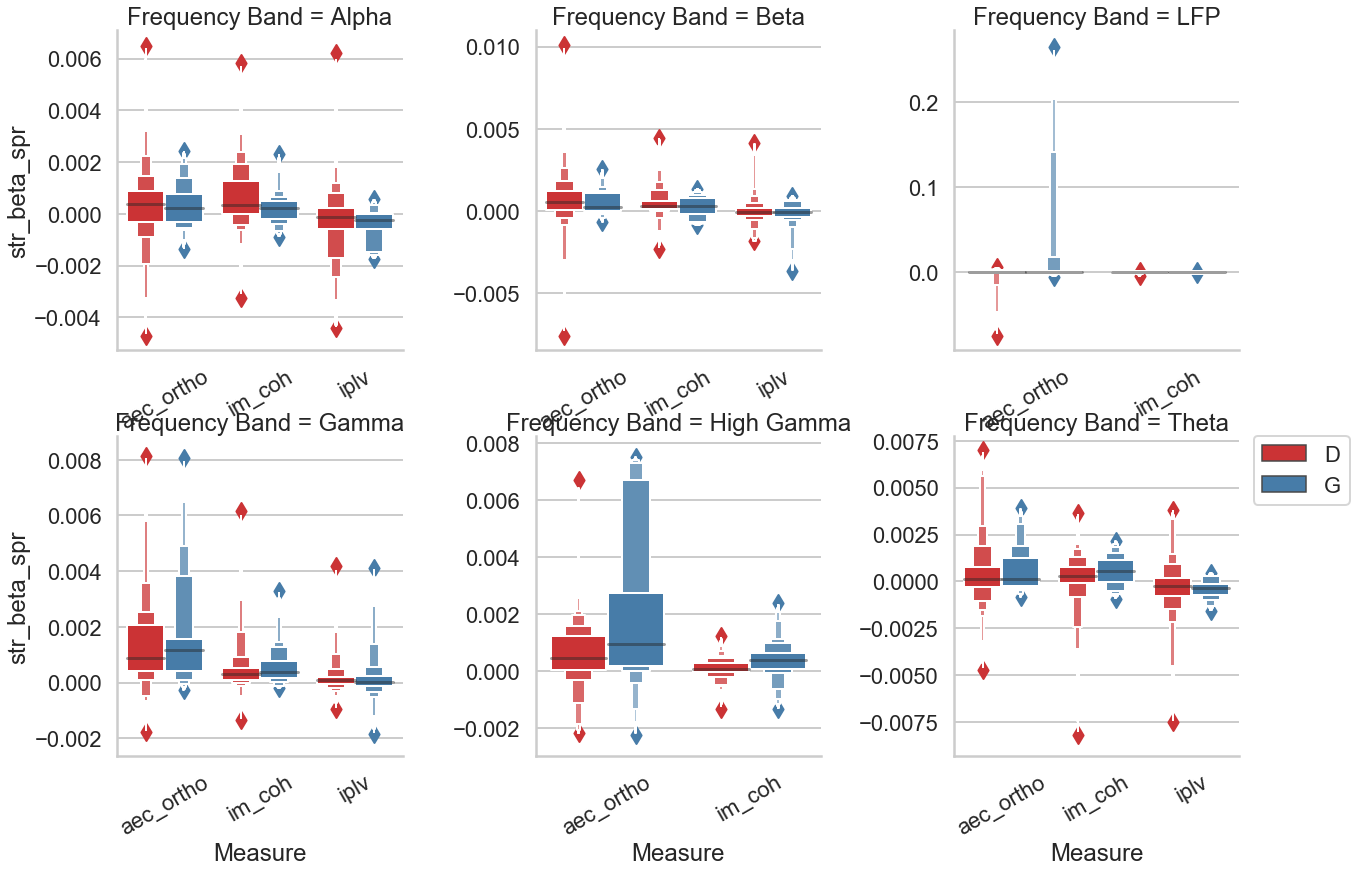

In [147]:
yvar = 'spr'
g = sns.FacetGrid(data=net_data[(net_data['Measure'] != 'aec') & (net_data['Measure'] != 'coh') & (net_data['Measure'] != 'plv')], col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=6, )
g.map(sns.boxenplot, 'Measure', 'str_beta_' + yvar, 'contacts', palette = 'Set1', 
      hue_order=['D','G'])
for a in g.axes:
    a.set_xticklabels(g.axes[0].xaxis.get_majorticklabels(),rotation=30)

g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
g.savefig(f"../img/contacts_{yvar}.pdf")

In [148]:
net_data = net_data.assign(type_diff_num = net_data['str_grid_beta_num'] - net_data['str_depth_beta_num'], 
                           type_diff_bin = net_data['str_grid_beta_bin'] - net_data['str_depth_beta_bin'],
                           type_diff_spr = net_data['str_grid_beta_spr'] - net_data['str_depth_beta_spr'])

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


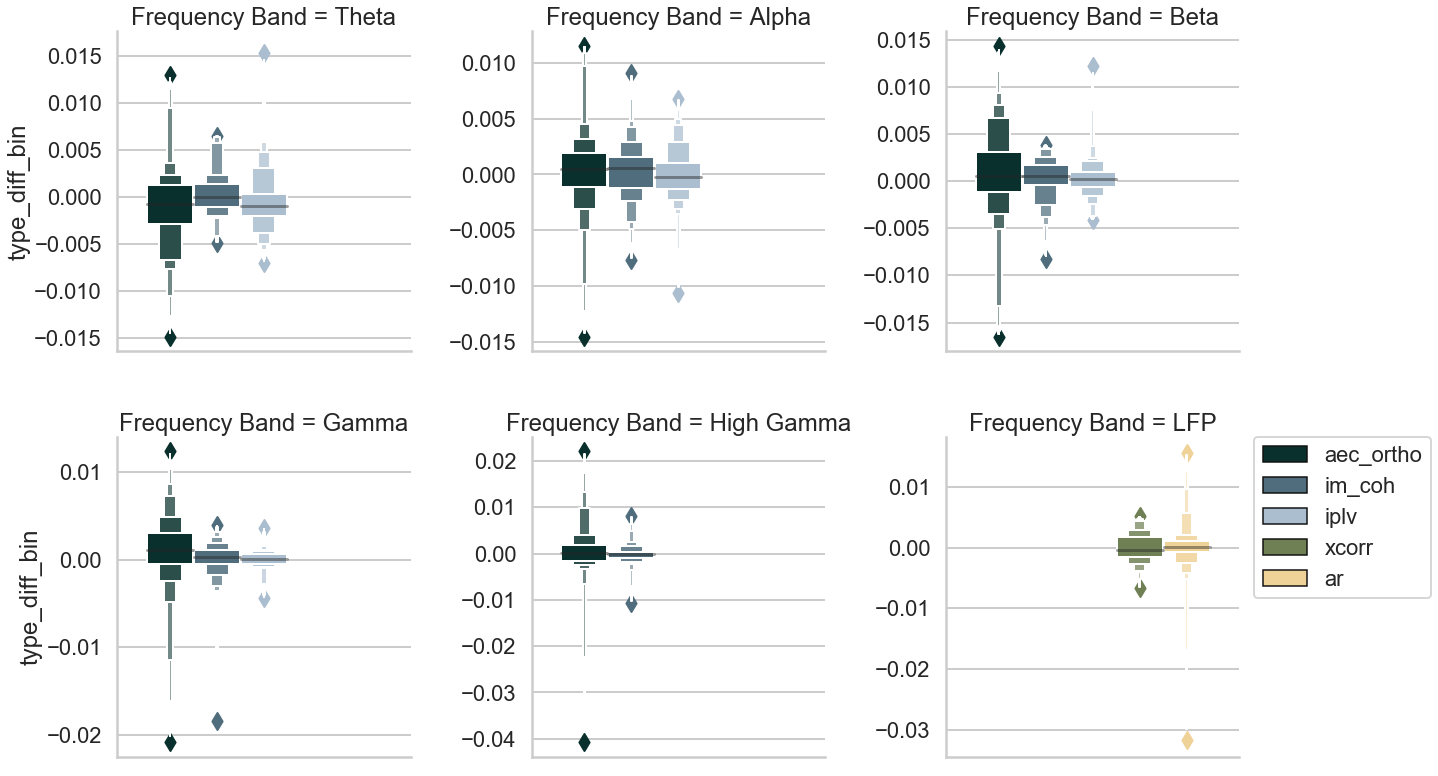

In [149]:
yvar = 'bin'

colors = ['#023732', '#476f84', '#a4bed5', '#72874e', '#fed789']
h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']

g=sns.FacetGrid(data=net_data, col="Frequency Band", col_wrap=3, col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'],
                sharex=False, sharey=False, height=6)
g.map(sns.boxenplot, "Frequency Band", "type_diff_" + yvar, "Measure",
             hue_order = h_order, palette=sns.color_palette(colors))
g.axes[5].legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
for a in g.axes:
    a.axes.xaxis.set_visible(False)

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


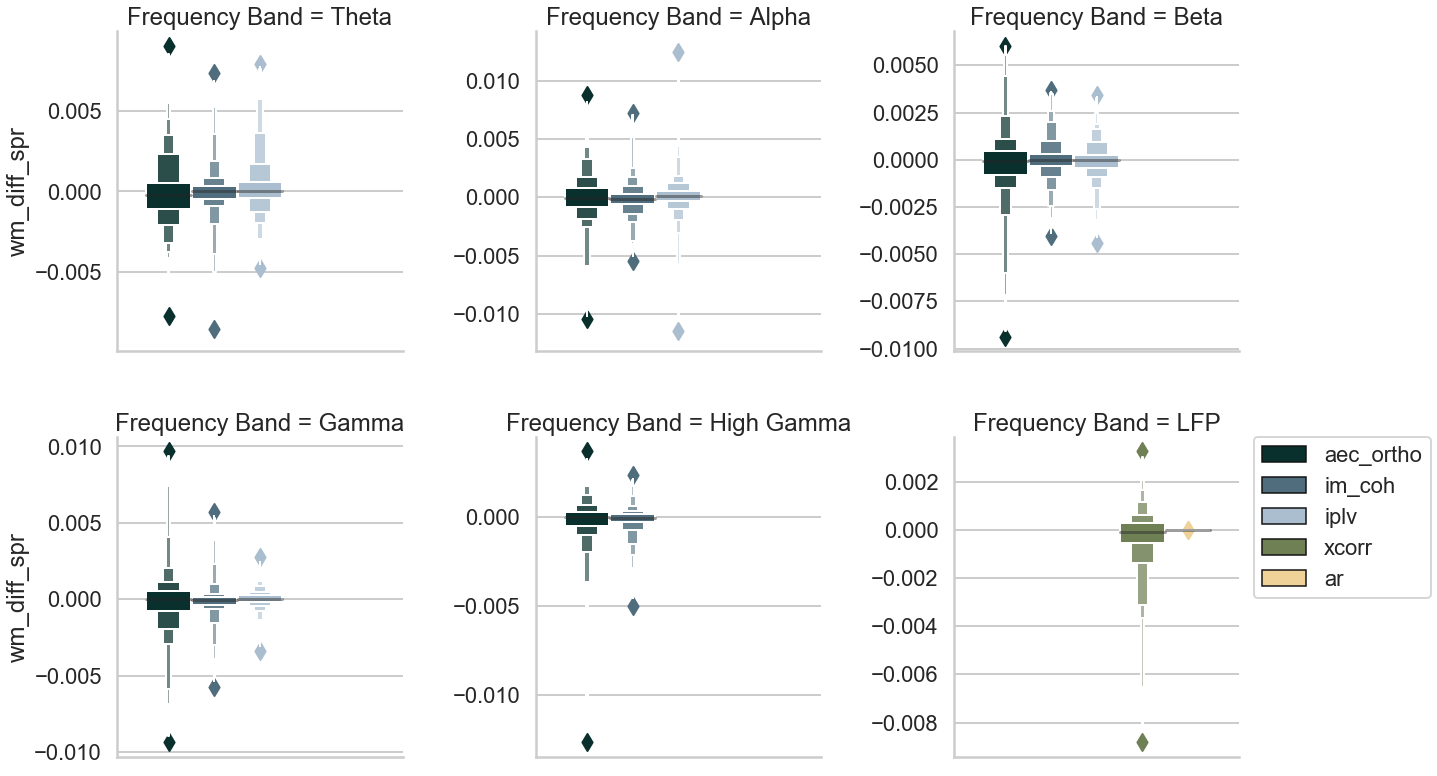

In [150]:
net_data = net_data.assign(wm_diff_num = net_data['str_gm_beta_num'] - net_data['str_wm_beta_num'], 
                           wm_diff_bin = net_data['str_gm_beta_bin'] - net_data['str_wm_beta_bin'],
                           wm_diff_spr = net_data['str_gm_beta_spr'] - net_data['str_wm_beta_spr'])

yvar = 'spr'

colors = ['#023732', '#476f84', '#a4bed5', '#72874e', '#fed789']
h_order = ['aec_ortho', 'im_coh', 'iplv', 'xcorr', 'ar']

g=sns.FacetGrid(data=net_data, col="Frequency Band", col_wrap=3, col_order = ['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'],
                sharex=False, sharey=False, height=6)
g.map(sns.boxenplot, "Frequency Band", "wm_diff_" + yvar, "Measure",
             hue_order = h_order, palette=sns.color_palette(colors))
g.axes[5].legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
for a in g.axes:
    a.axes.xaxis.set_visible(False)

In [151]:
net_data.subj.nunique()

144

## Variance by system

In [152]:
# load system data
sys = pd.read_csv(f'{RAM_dir}group_analysis/win_{win}/contact_sys.csv', index_col=0)


In [153]:
# check number of contacts
# contacts that are really far away end up labelled as vis
sys['sys'].value_counts()

Vis            97140
Default         4647
Limbic          2391
SalVentAttn     1940
SomMot          1597
Cont            1416
DorsAttn        1320
Name: sys, dtype: int64

In [154]:
sys.groupby(['subj','sys']).min_d.mean().head(25)

subj    sys        
R1001P  Cont            13.462925
        Default         16.000491
        DorsAttn        12.306150
        Limbic          20.120398
        SalVentAttn     15.065420
        SomMot          13.164589
        Vis             14.353137
R1002P  Cont            14.499693
        Default         20.114818
        DorsAttn        16.196721
        Limbic          19.731470
        SalVentAttn     19.326486
        SomMot          13.525720
        Vis             16.885360
R1003P  Vis                   NaN
R1004D  Cont           120.370063
        Default        153.841812
        SalVentAttn    128.240812
R1006P  Vis                   NaN
R1008J  Default         15.089609
        DorsAttn        16.060019
        Limbic          16.926507
        SalVentAttn     16.998840
        Vis             15.265479
R1009W  Vis                   NaN
Name: min_d, dtype: float64

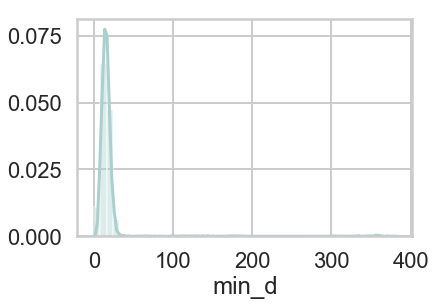

In [155]:
# how well are the MNI coordinates doing? Are centroids usually close?
sns.distplot(sys['min_d'].dropna())

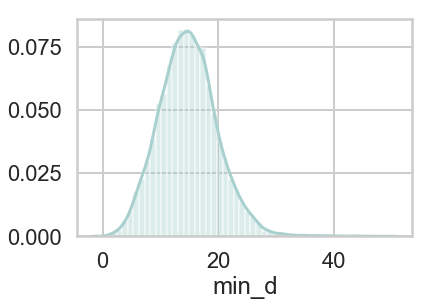

In [156]:
# get reid of contacts that clearly had poor match - greater than 2 std
sys.loc[sys['min_d'] > sys['min_d'].mean() + sys['min_d'].std(),['sys', 'parc', 'min_d', 'region']] = np.nan
sns.distplot(sys['min_d'].dropna())

In [157]:
# merge
node_data = pd.merge(node_data, sys, on=['subj', 'elec', 'region', 'x' ,'y', 'z', 'race', 
                                         'hand', 'gender', 'type', 'age'])
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2336910 entries, 0 to 2336909
Data columns (total 29 columns):
elec            object
band_measure    object
n_tp            int64
elec_spike      float64
elec_in_soz     int64
elec_in_ict     int64
ti_beta_bin     float64
ti_beta_num     float64
ti_beta_spr     float64
str_beta_spr    float64
str_beta_bin    float64
str_beta_num    float64
fc_measure      object
band            object
region          object
x               float64
y               float64
z               float64
type            object
subj            object
hand            object
age             float64
gender          object
race            float64
wm              float64
parc            object
sys             object
hem             object
min_d           float64
dtypes: float64(14), int64(3), object(12)
memory usage: 534.9+ MB


In [158]:
# get region -> system mapping to see if the MNI labels are any good
node_data.dropna(inplace=True, axis=0, subset=['min_d'])
reg_sys_map = node_data.groupby(['subj', 'elec'])[['region','sys']].head()
reg_sys_map.to_csv(f'{RAM_dir}group_analysis/win_{win}/reg_sys_map{detector}.csv')
reg_sys_map.head()


region      sys
0  superiortemporal  Default
1  superiortemporal  Default
2  superiortemporal  Default
3  superiortemporal  Default
4  superiortemporal  Default

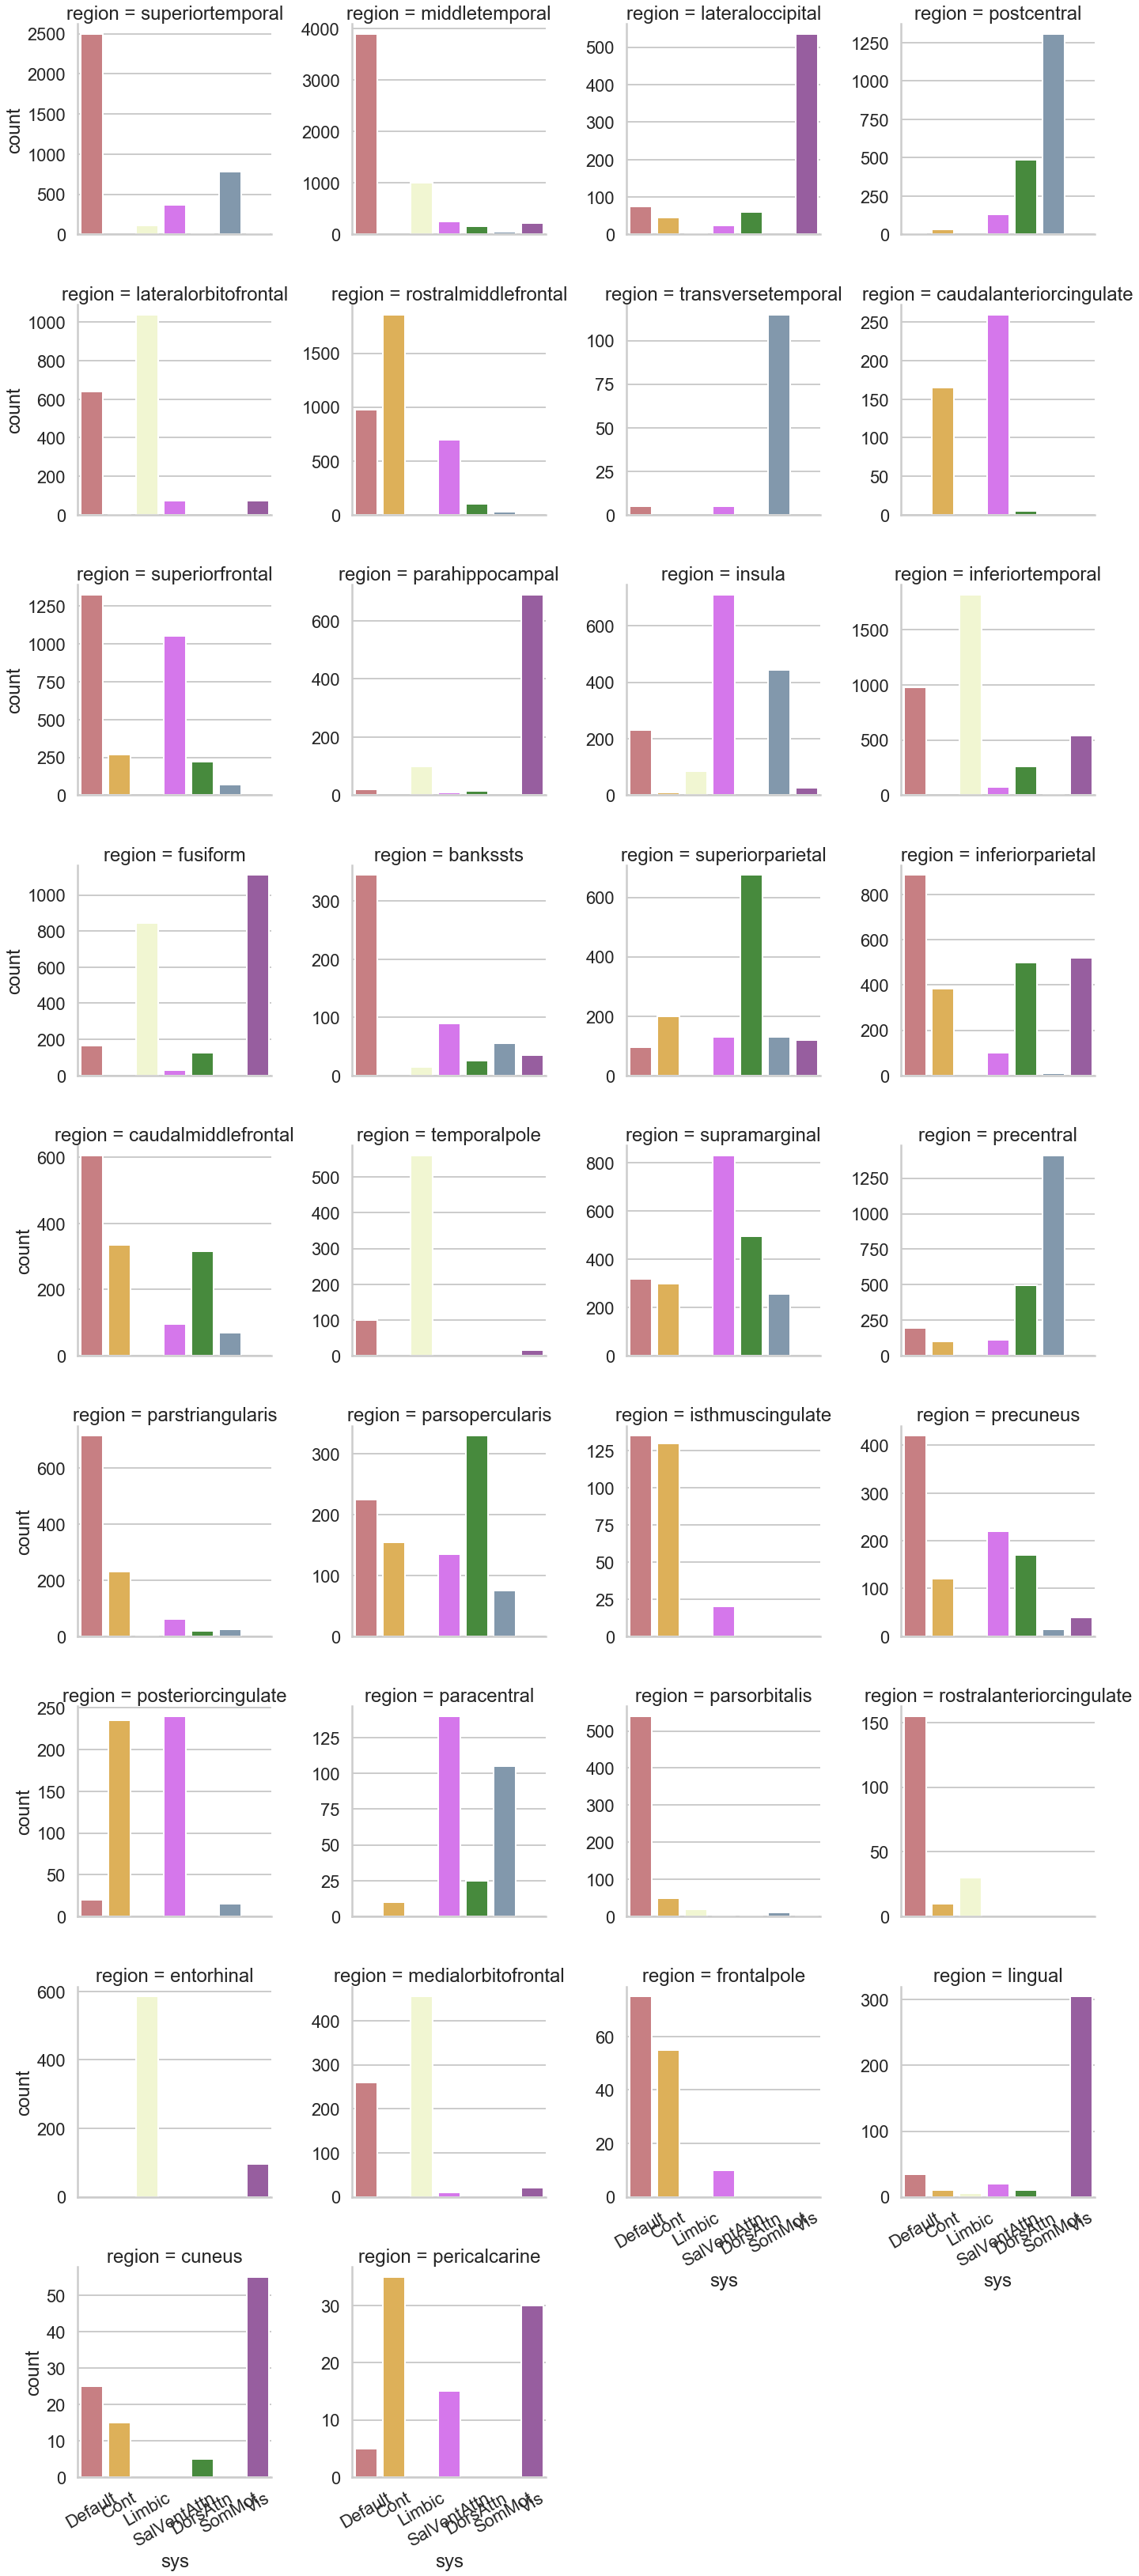

In [159]:
sys_colors = ['#d37379', '#f3b743', '#f5fccc', '#e164fe', '#3e9730', '#7b98b3', '#9f53aa']
sys_pal = sns.color_palette(sys_colors)
p = sns.catplot(data=reg_sys_map, x='sys', col='region', kind='count', col_wrap=4, sharey=False,
           order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'],
           palette=sys_pal)
for a in p.axes:
    a.set_xticklabels(a.xaxis.get_majorticklabels(), rotation=30)
p.savefig(f'{RAM_dir}img/MNI_labels.png')

In [160]:
# z-score within subject node_data.drop(['scale_num', 'scale_bin'], axis=1, inplace=True) # comment this out if defining scaled vars for the first time
node_data.insert(5, 'scale_num', node_data.groupby(['subj', 'band_measure'])['str_beta_num'].transform(
    lambda x: sp.stats.zscore(x)))
node_data.insert(5, 'scale_bin', node_data.groupby(['subj', 'band_measure'])['str_beta_bin'].transform(
    lambda x: sp.stats.zscore(x)))
node_data.insert(5, 'scale_spr', node_data.groupby(['subj', 'band_measure'])['str_beta_spr'].transform(
    lambda x: sp.stats.zscore(x)))
# average over systems, so every subj has 1 pt per sys (if they had coverage there)
sys_avg = node_data.groupby(['subj', 'band', 'fc_measure', 'sys'])['scale_bin', 'scale_num', 'scale_spr'].median().reset_index()
sys_avg.head()
sys_avg.to_csv(f'{RAM_dir}group_analysis/win_{win}/sys_stats.csv')

/Users/stiso/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


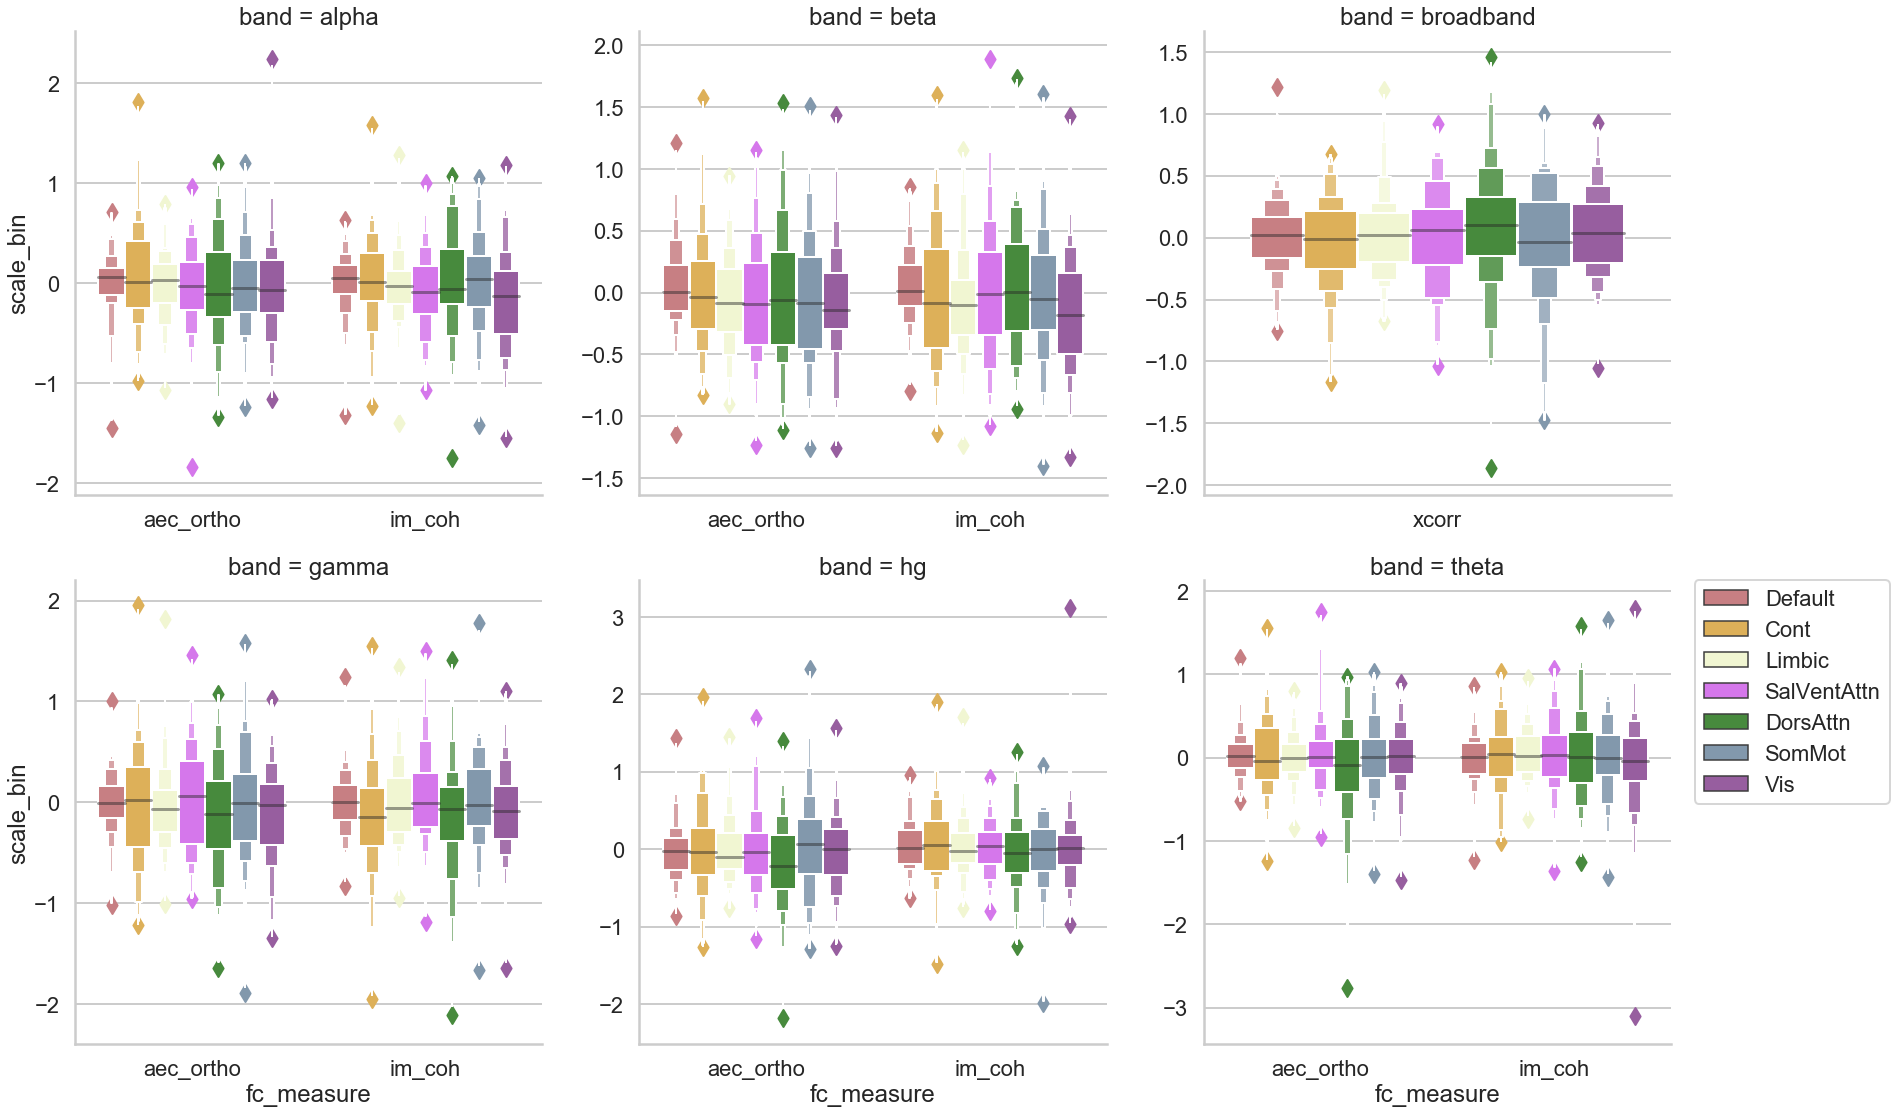

In [161]:
sys_avg = sys_avg[(sys_avg['fc_measure'] != 'aec') & (sys_avg['fc_measure'] != 'plv') & (sys_avg['fc_measure'] != 'coh')
                 & (sys_avg['fc_measure'] != 'iplv') & (sys_avg['fc_measure'] != 'ar')]
g = sns.FacetGrid(data=sys_avg, col='band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'fc_measure', 'scale_bin', 'sys', palette = sys_pal,
     hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-2,2)
    
g.savefig("../img/reg_sys.pdf")

## Clinical Data

In [162]:
clinical = pd.read_csv(f'{RAM_dir}RAM_Stiso.csv')

In [163]:
clinical.head()

Subject Lesional Institution   Age Sex       Race     Ethnicity  \
0        1      NaN        Penn  50.0   F      Black  Non-Hispanic   
1        2      NaN        Penn  51.0   F  Caucasian  Non-Hispanic   
2        3      NaN        Penn  41.0   F  Caucasian  Non-Hispanic   
3        4      NaN   Dartmouth  54.0   F  Caucasian  Non-Hispanic   
4        5      NaN        Penn  22.0   F  Caucasian  Non-Hispanic   

     Handedness  Education  SeizureAge Etiology  
0         Right       13.0        20.0  Unknown  
1         Right       16.0        34.0  Unknown  
2  Ambidextrous       13.0        37.0  Unknown  
3         Right       12.0         6.0    Other  
4           NaN        NaN         NaN      NaN

In [164]:
clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 11 columns):
Subject        408 non-null int64
Lesional       40 non-null object
Institution    408 non-null object
Age            388 non-null float64
Sex            392 non-null object
Race           372 non-null object
Ethnicity      368 non-null object
Handedness     372 non-null object
Education      296 non-null float64
SeizureAge     366 non-null float64
Etiology       339 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 35.1+ KB


In [165]:
clinical.describe()

Subject         Age   Education  SeizureAge
count  408.000000  388.000000  296.000000  366.000000
mean   204.500000   36.579897   13.866554   18.198361
std    117.923704   11.538333    2.662342   12.973057
min      1.000000   17.000000    3.000000    0.000000
25%    102.750000   26.750000   12.000000    8.000000
50%    204.500000   36.000000   14.000000   16.000000
75%    306.250000   46.000000   16.000000   26.000000
max    408.000000   66.000000   24.000000   59.000000

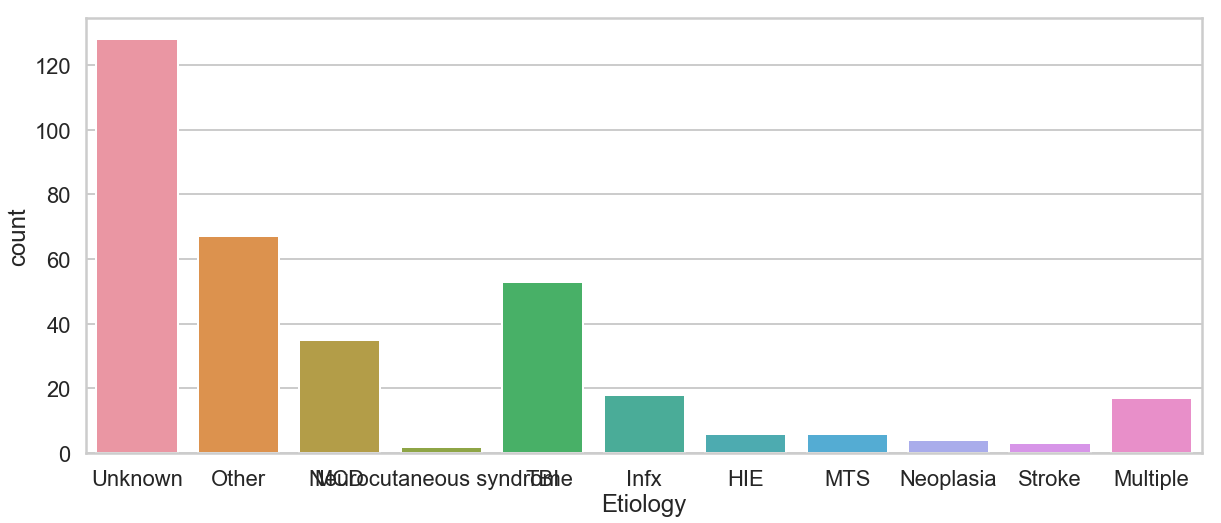

In [166]:
fig = plt.figure(figsize=(20,8))
sns.countplot(data=clinical, x='Etiology')

In [167]:
clinical['Etiology'].value_counts()

Unknown                    128
Other                       67
TBI                         53
MCD                         35
Infx                        18
Multiple                    17
MTS                          6
HIE                          6
Neoplasia                    4
Stroke                       3
Neurocutaneous syndrome      2
Name: Etiology, dtype: int64

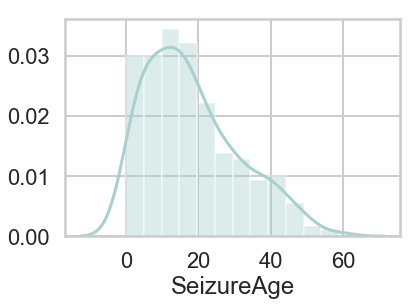

In [168]:
sns.distplot(clinical['SeizureAge'].dropna())

In [169]:
# get subject to the same naming convention
clinical['subj'] = clinical.apply(lambda x: 'R1' + '{0:0=3d}'.format(x['Subject']) + x['Institution'][0], axis=1)
clinical.drop(['Subject', 'Age', 'Sex', 'Race', 'Handedness'], axis=1, inplace=True)
clinical.head()

Lesional Institution     Ethnicity  Education  SeizureAge Etiology    subj
0      NaN        Penn  Non-Hispanic       13.0        20.0  Unknown  R1001P
1      NaN        Penn  Non-Hispanic       16.0        34.0  Unknown  R1002P
2      NaN        Penn  Non-Hispanic       13.0        37.0  Unknown  R1003P
3      NaN   Dartmouth  Non-Hispanic       12.0         6.0    Other  R1004D
4      NaN        Penn  Non-Hispanic        NaN         NaN      NaN  R1005P

In [170]:
# add 'nonlesional' category
clinical.loc[clinical['Lesional'].isna(),'Lesional'] = 'Nonlesional'
clinical.head()

Lesional Institution     Ethnicity  Education  SeizureAge Etiology  \
0  Nonlesional        Penn  Non-Hispanic       13.0        20.0  Unknown   
1  Nonlesional        Penn  Non-Hispanic       16.0        34.0  Unknown   
2  Nonlesional        Penn  Non-Hispanic       13.0        37.0  Unknown   
3  Nonlesional   Dartmouth  Non-Hispanic       12.0         6.0    Other   
4  Nonlesional        Penn  Non-Hispanic        NaN         NaN      NaN   

     subj  
0  R1001P  
1  R1002P  
2  R1003P  
3  R1004D  
4  R1005P

In [171]:
# merge with net data
subj_idx = [x in net_data.subj.unique() for x in clinical.subj]
net_data = pd.merge(net_data,clinical[subj_idx], on='subj', how='outer')
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4770 entries, 0 to 4769
Data columns (total 54 columns):
band_measure              4770 non-null object
n_tp                      4770 non-null int64
str_beta_bin              4665 non-null float64
str_beta_num              4685 non-null float64
str_beta_spr              4697 non-null float64
ti_beta_bin               4675 non-null float64
ti_beta_num               4688 non-null float64
ti_beta_spr               4692 non-null float64
str_soz_beta_bin          3316 non-null float64
str_soz_beta_num          3320 non-null float64
str_soz_beta_spr          3326 non-null float64
str_not_soz_beta_num      3320 non-null float64
str_spike_beta_num        3140 non-null float64
str_not_soz_beta_spr      3320 non-null float64
str_not_soz_beta_bin      3301 non-null float64
str_spike_beta_bin        3137 non-null float64
str_spike_beta_spr        3146 non-null float64
str_not_spike_beta_bin    3126 non-null float64
Measure                   4770 n

In [172]:
net_data.subj.nunique()

144

In [173]:
# save
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/clinical{detector}.csv')

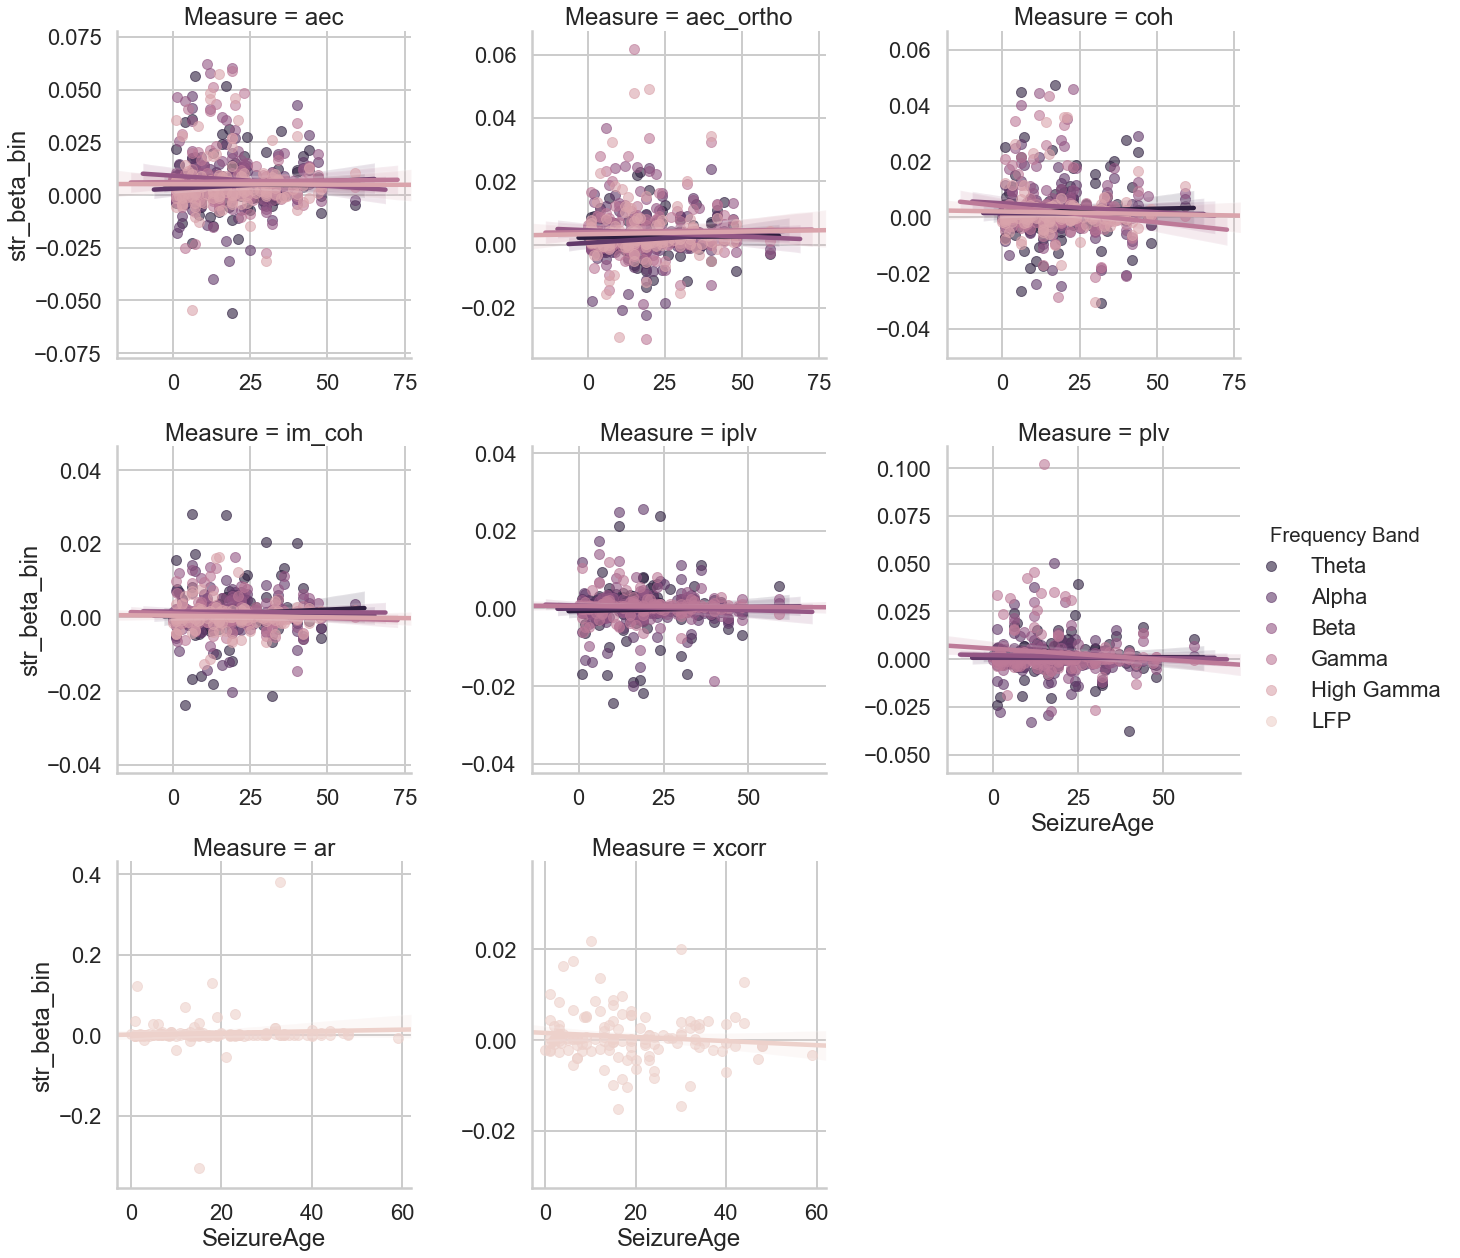

In [174]:
yvar='bin'
sns.lmplot(data=net_data, x='SeizureAge', y='str_beta_' + yvar, hue='Frequency Band', col="Measure", 
           col_wrap=3, height=6, sharex=False, sharey=False, 
           palette=sns.color_palette(sns.cubehelix_palette(6, reverse=True)), 
           scatter_kws={'s':100, 'alpha':.6}, 
           hue_order=['Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma', 'LFP'])
plt.savefig(f"../img/seizure_onset_{yvar}_{detector}.png")

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the boxenplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


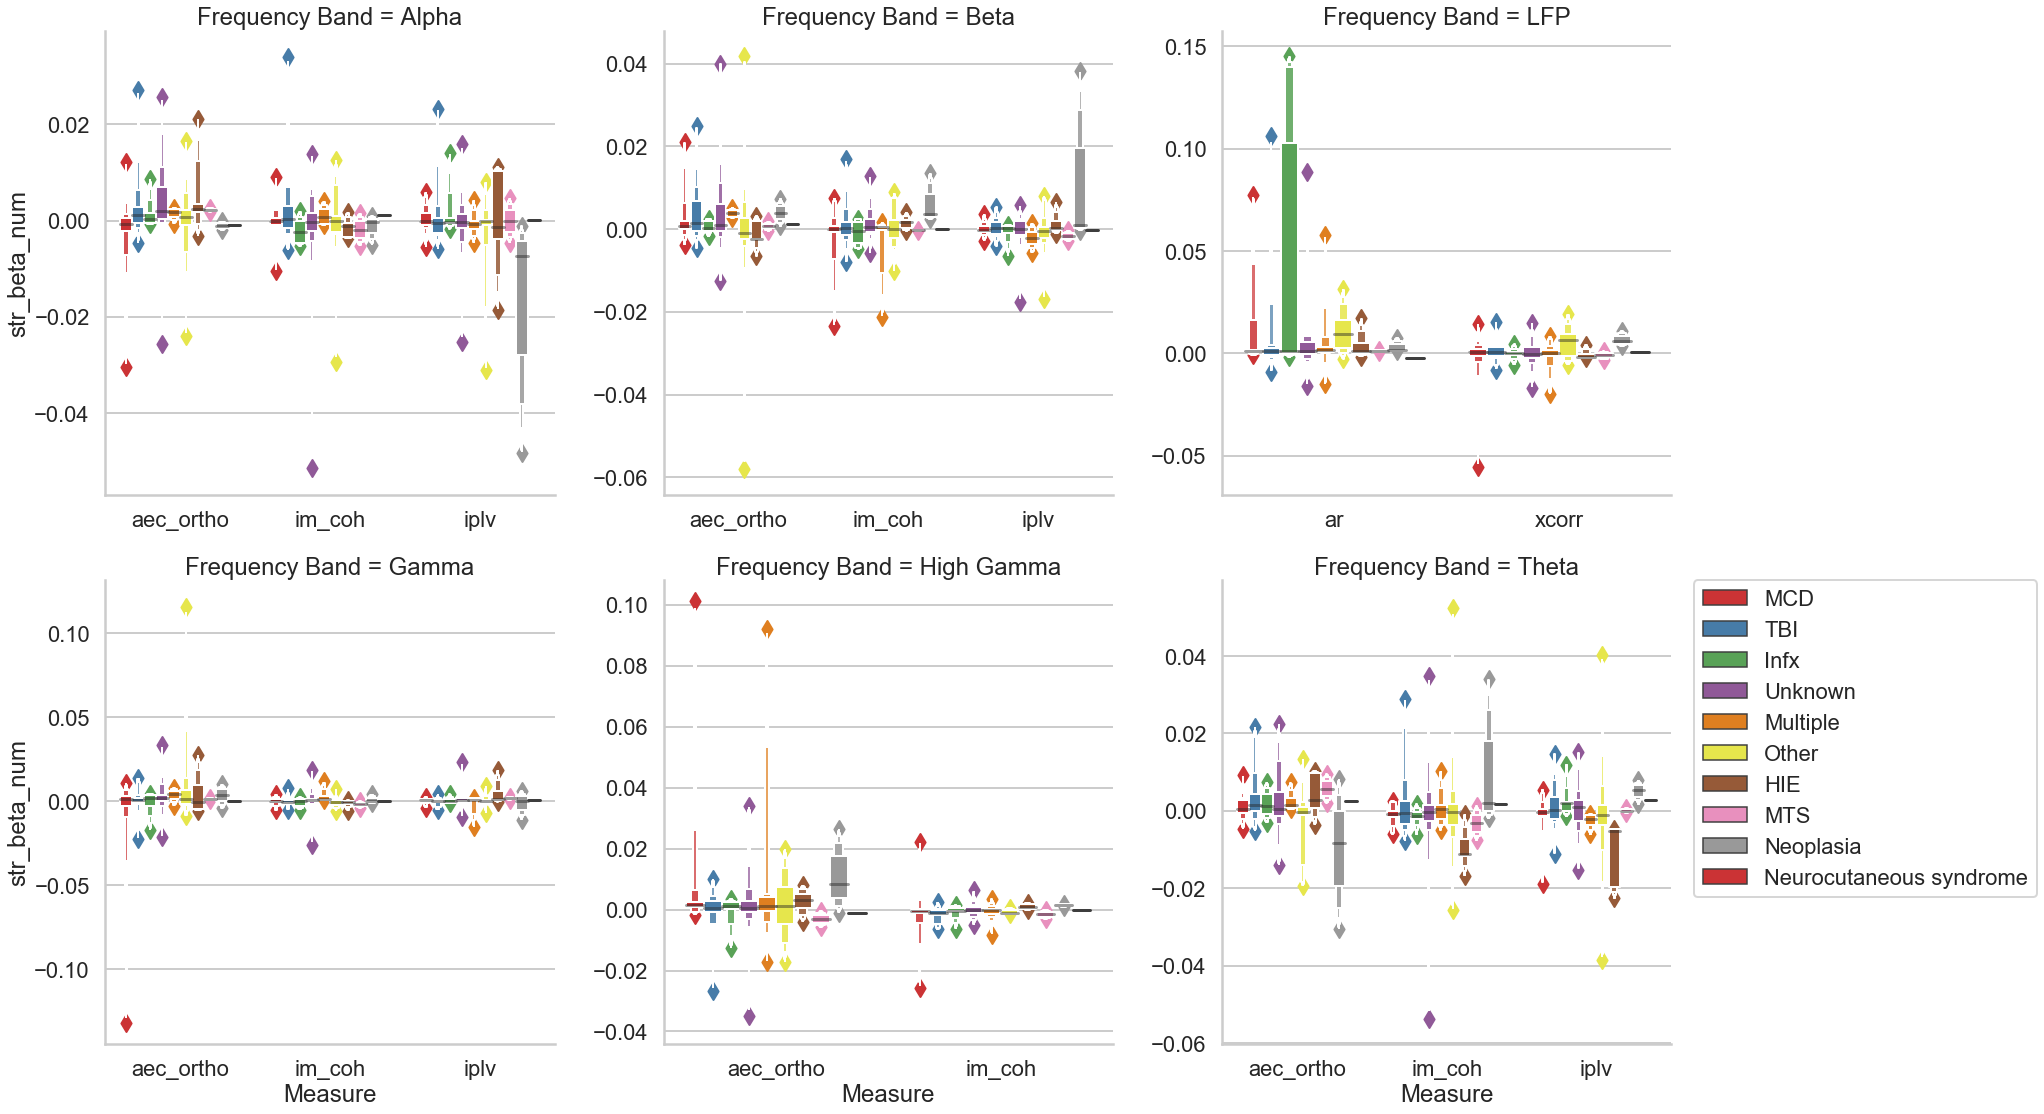

In [175]:
yvar = 'num'
g = sns.FacetGrid(data=net_data[(net_data['Measure'] != 'aec') & (net_data['Measure'] != 'coh') & (net_data['Measure'] != 'plv')], 
                  col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'Measure', 'str_beta_' + yvar, 'Etiology', palette='Set1')
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
g.savefig(f'../img/etiology_{yvar}.pdf')

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the boxenplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


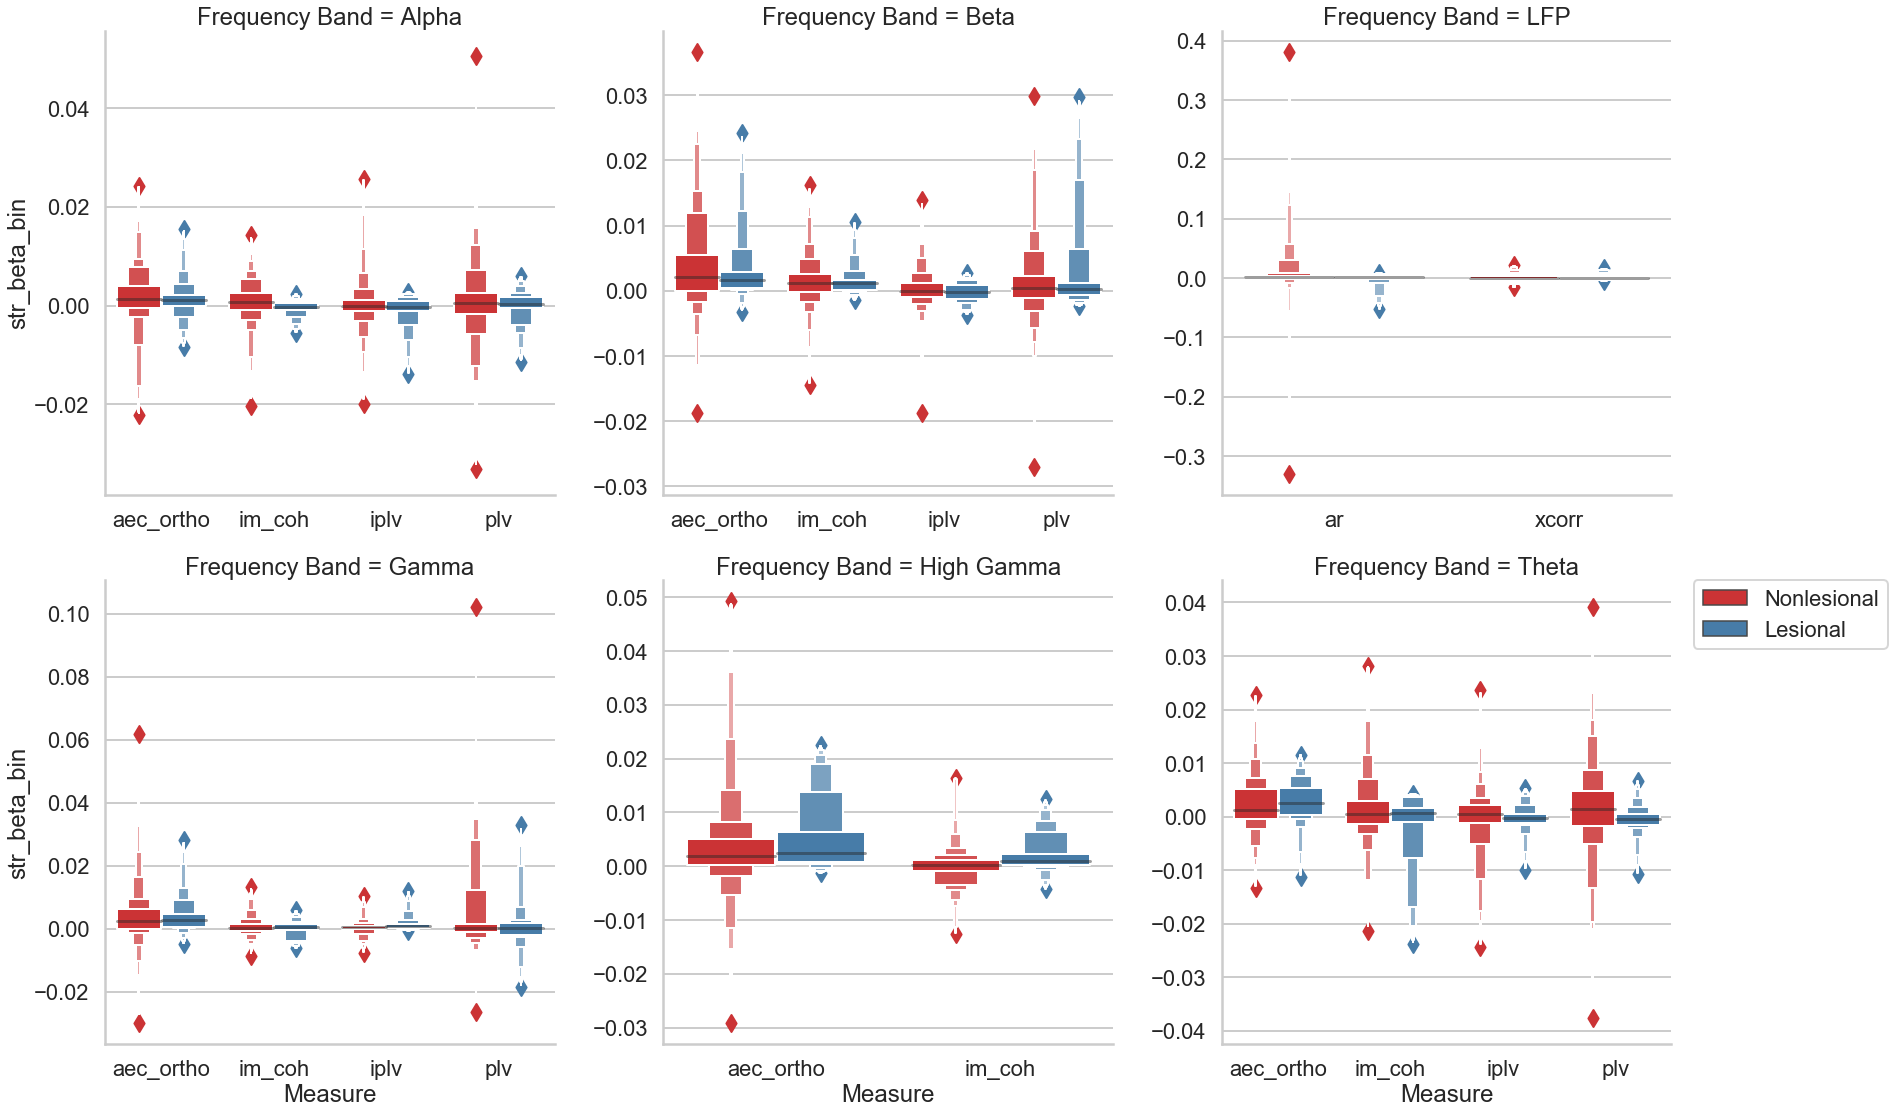

In [176]:
yvar = 'spr'
g = sns.FacetGrid(data=net_data[(net_data['Measure'] != 'aec') & (net_data['Measure'] != 'coh')], col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8)
g.map(sns.boxenplot, 'Measure', 'str_beta_bin', 'Lesional', palette='Set1')
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
g.savefig(f'../img/lesional_{yvar}.pdf')

### Categorize SOZ

In [177]:
# check labels of elecs in soz for which sys they are in
flag = 'spike' # spike or soz

epilepsy_type = pd.DataFrame(data={'subj':net_data.subj.unique(), 
                                   'locus':np.empty(net_data.subj.unique().shape),
                                  'hem':np.empty(net_data.subj.unique().shape)})
for index,row in epilepsy_type.iterrows():
    if flag == 'spike':
        curr = node_data[(node_data['subj'] == row.subj)]
        curr = curr[curr['elec_spike'] == curr['elec_spike'].max()]    
    else:
        curr = node_data[(node_data['subj'] == row.subj) & (node_data['elec_in_soz'] == 1)]
    if (np.shape(curr)[0] == 0):
        epilepsy_type.loc[index, 'locus'] = np.nan
        epilepsy_type.loc[index,'hem'] = np.nan
    else:
        epilepsy_type.loc[index,'locus'] = curr.sys.mode()[0]
        epilepsy_type.loc[index, 'hem']= curr.hem.mode()[0]
    
epilepsy_type.head()           

subj     locus hem
0  R1284N    SomMot  LH
1  R1276D    Limbic  LH
2  R1263C    Limbic  LH
3  R1260D       Vis  LH
4  R1250N  DorsAttn  RH

In [178]:
node_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330360 entries, 0 to 2336909
Data columns (total 32 columns):
elec            330360 non-null object
band_measure    330360 non-null object
n_tp            330360 non-null int64
elec_spike      330360 non-null float64
elec_in_soz     330360 non-null int64
scale_spr       269070 non-null float64
scale_bin       250410 non-null float64
scale_num       269070 non-null float64
elec_in_ict     330360 non-null int64
ti_beta_bin     326340 non-null float64
ti_beta_num     327960 non-null float64
ti_beta_spr     327960 non-null float64
str_beta_spr    327960 non-null float64
str_beta_bin    326341 non-null float64
str_beta_num    327960 non-null float64
fc_measure      330360 non-null object
band            330360 non-null object
region          302070 non-null object
x               330360 non-null float64
y               330360 non-null float64
z               330360 non-null float64
type            330360 non-null object
subj            3303

In [179]:
epilepsy_type.dropna().subj.nunique()

110

In [180]:
node_data.region.unique()

array(['superiortemporal', 'middletemporal', 'lateraloccipital',
       'postcentral', 'lateralorbitofrontal', 'rostralmiddlefrontal', nan,
       'transversetemporal', 'caudalanteriorcingulate', 'superiorfrontal',
       'parahippocampal', 'insula', 'inferiortemporal', 'fusiform',
       'bankssts', 'superiorparietal', 'inferiorparietal',
       'caudalmiddlefrontal', 'temporalpole', 'supramarginal',
       'precentral', 'parstriangularis', 'parsopercularis',
       'isthmuscingulate', 'precuneus', 'posteriorcingulate',
       'paracentral', 'parsorbitalis', 'rostralanteriorcingulate',
       'entorhinal', 'medialorbitofrontal', 'frontalpole', 'lingual',
       'cuneus', 'pericalcarine'], dtype=object)

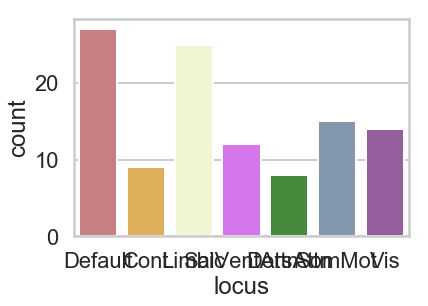

In [181]:
sns.countplot(data=epilepsy_type, x='locus', palette = sys_pal, 
              order = ['Default', 'Cont','Limbic', 'SalVentAttn','DorsAttn', 'SomMot','Vis'],
             hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])

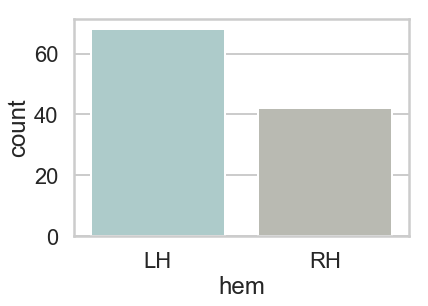

In [182]:
sns.countplot(data=epilepsy_type, x='hem')

In [183]:
# add locus back to big data frames
#net_data.drop(['locus', 'hem'],axis=1,inplace=True)
net_data = pd.merge(net_data, epilepsy_type, on='subj',how='outer')
#node_data = pd.merge(node_data, epilepsy_type, on='subj')
net_data.head()

band_measure  n_tp  str_beta_bin  str_beta_num  str_beta_spr  \
0        alpha_aec   480      0.003289     -0.000688      0.001633   
1  alpha_aec_ortho   480      0.000066     -0.000914      0.000383   
2        alpha_coh   480      0.003338     -0.000122      0.001127   
3     alpha_im_coh   480      0.001214     -0.000171      0.000530   
4       alpha_iplv   480     -0.001016     -0.000401     -0.000056   

   ti_beta_bin  ti_beta_num  ti_beta_spr  str_soz_beta_bin  str_soz_beta_num  \
0    -0.015989     0.003432    -0.006628          0.002158          0.000343   
1    -0.000886     0.001980     0.000324          0.001590          0.000489   
2    -0.027313     0.001969    -0.005895          0.002429          0.001110   
3    -0.019836    -0.000050    -0.003499          0.000904          0.000338   
4     0.005466     0.001384    -0.000108          0.001235          0.001718   

  ...   wm_diff_bin  wm_diff_spr     Lesional  Institution     Ethnicity  \
0 ...      0.000924    -0.000620  Nonlesional        NINDS  Non-Hispanic   
1 ...      0.000327     0.000716  Nonlesional        NINDS  Non-Hispanic   
2 ...     -0.001440    -0.000833  Nonlesional        NINDS  Non-Hispanic   
3 ...     -0.001673    -0.000553  Nonlesional        NINDS  Non-Hispanic   
4 ...      0.000958     0.000935  Nonlesional        NINDS  Non-Hispanic   

   Education  SeizureAge  Etiology   locus  hem  
0        NaN        15.0       MCD  SomMot   LH  
1        NaN        15.0       MCD  SomMot   LH  
2        NaN        15.0       MCD  SomMot   LH  
3        NaN        15.0       MCD  SomMot   LH  
4        NaN        15.0       MCD  SomMot   LH  

[5 rows x 56 columns]

In [184]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4770 entries, 0 to 4769
Data columns (total 56 columns):
band_measure              4770 non-null object
n_tp                      4770 non-null int64
str_beta_bin              4665 non-null float64
str_beta_num              4685 non-null float64
str_beta_spr              4697 non-null float64
ti_beta_bin               4675 non-null float64
ti_beta_num               4688 non-null float64
ti_beta_spr               4692 non-null float64
str_soz_beta_bin          3316 non-null float64
str_soz_beta_num          3320 non-null float64
str_soz_beta_spr          3326 non-null float64
str_not_soz_beta_num      3320 non-null float64
str_spike_beta_num        3140 non-null float64
str_not_soz_beta_spr      3320 non-null float64
str_not_soz_beta_bin      3301 non-null float64
str_spike_beta_bin        3137 non-null float64
str_spike_beta_spr        3146 non-null float64
str_not_spike_beta_bin    3126 non-null float64
Measure                   4770 n

In [185]:
net_data.subj.nunique()

144

## Net plots with category by locus

/Users/stiso/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxenplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


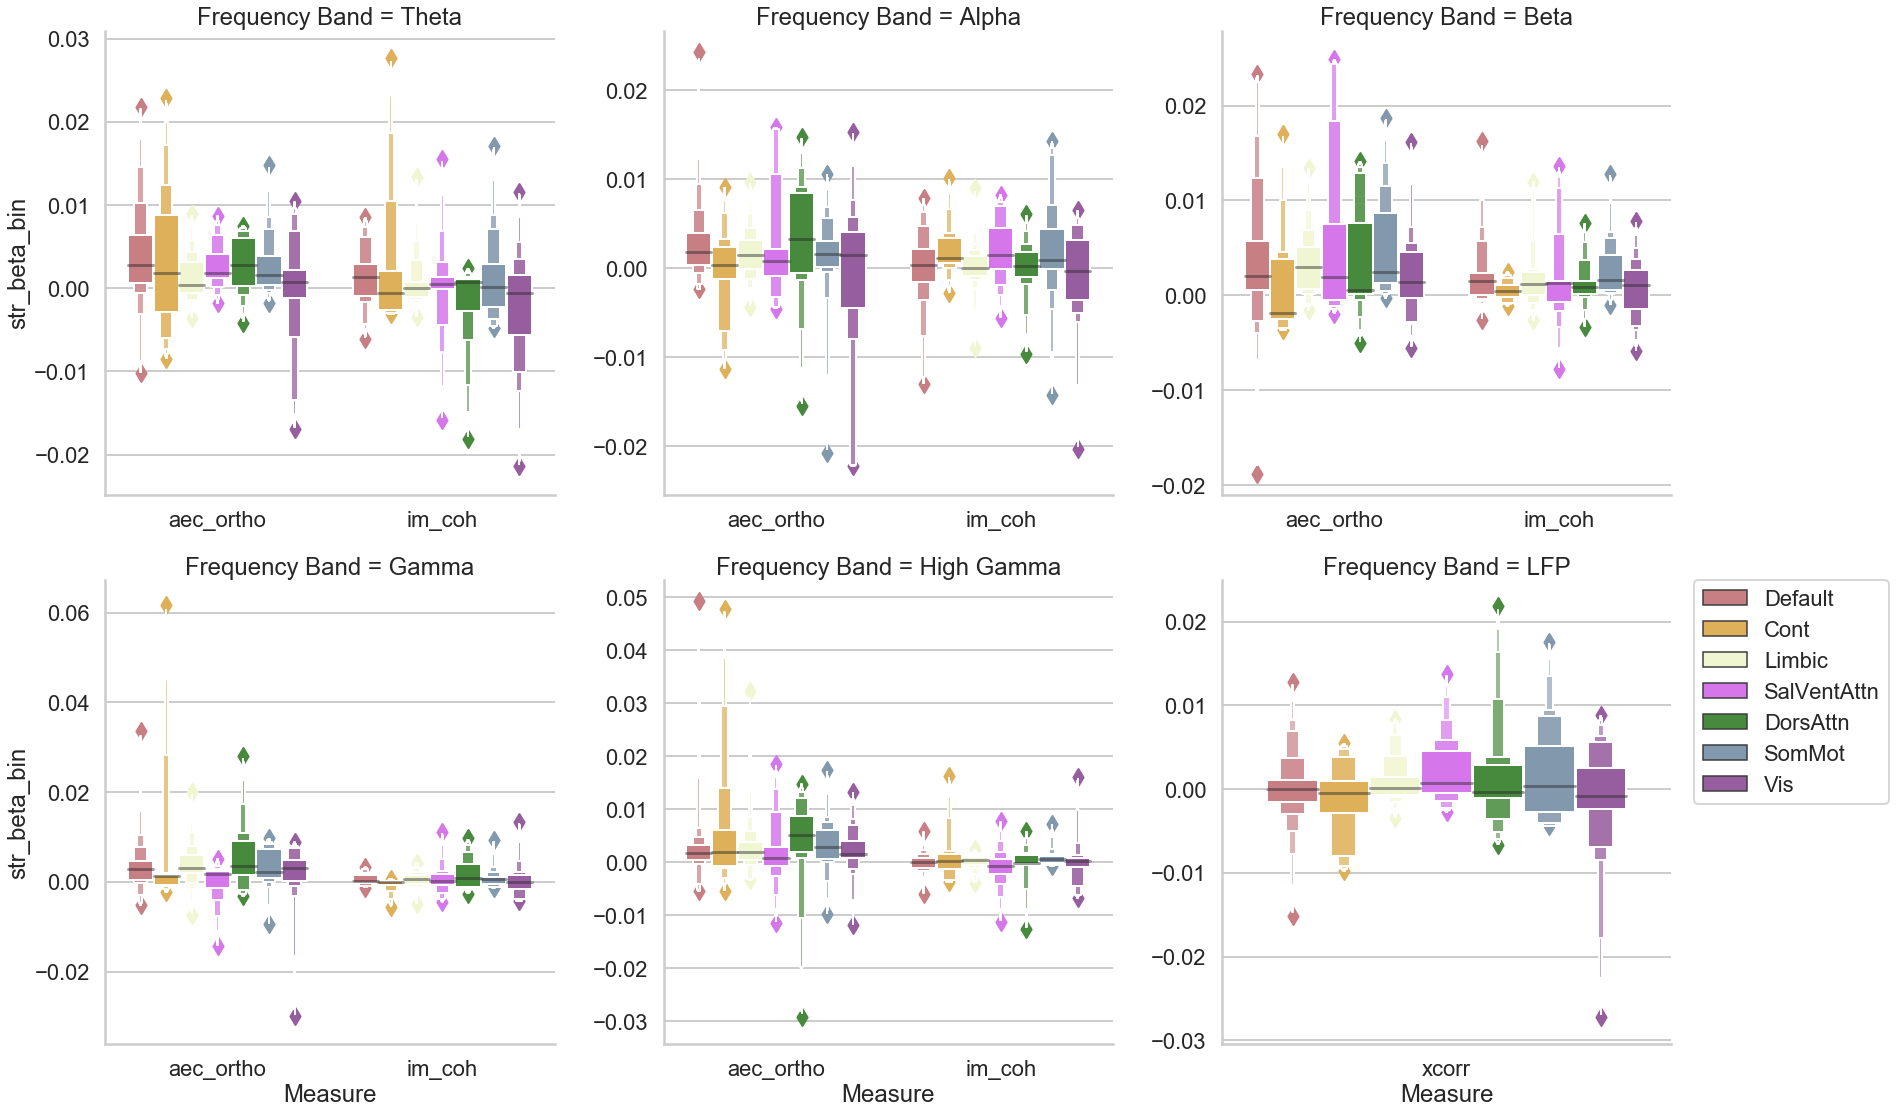

In [186]:
yvar = 'bin'
g = sns.FacetGrid(data=net_data[(net_data.Measure != 'aec') & (net_data.Measure != 'coh') & 
                                (net_data.Measure != 'plv') & (net_data.Measure != 'iplv') & (net_data.Measure != 'ar')], col='Frequency Band' ,col_wrap = 3, 
                  sharex=False, sharey=False, legend_out=True, height=8, col_order = ['Theta', 'Alpha', 'Beta', 'Gamma','High Gamma', 'LFP'])
g.map(sns.boxenplot, 'Measure', 'str_beta_' + yvar, 'locus', palette = sys_pal, 
      hue_order = ['Default', 'Cont', 'Limbic', 'SalVentAttn', 'DorsAttn', 'SomMot', 'Vis'])
g.axes[5].legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0.)
#for ax in g.axes:
#    ax.set_ylim(-5,5)
    
g.savefig(f'../img/soz_region_{yvar}{detector}.pdf')

In [187]:
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/sys_{flag}{detector}.csv')

## Behavior

In [188]:
task_data = pd.read_csv(f'{RAM_dir}group_analysis/task_performance.csv', index_col=0)
task_data.reset_index(inplace=True)
task_data.head(10)

subj        YC  TH       PAL  catFR        FR
0  R1001P  0.345526 NaN  0.041370    NaN  0.546573
1  R1002P       NaN NaN  0.492335    NaN  0.945857
2  R1003P       NaN NaN  0.083711    NaN  0.602817
3  R1004D       NaN NaN       NaN  0.625       NaN
4  R1006P  0.401778 NaN       NaN    NaN  0.779412
5  R1008J  0.530724 NaN       NaN    NaN       NaN
6  R1009W  0.183700 NaN       NaN    NaN       NaN
7  R1010J  0.358207 NaN       NaN    NaN  0.825373
8  R1013E  0.182021 NaN       NaN    NaN       NaN
9  R1014D  0.354468 NaN       NaN    NaN       NaN

In [189]:
# count missing values
task_data.apply(lambda x: sum(x.isnull())/x.size*100, axis=0)

subj      0.000000
YC       78.597786
TH       86.715867
PAL      76.014760
catFR    62.730627
FR       40.959410
dtype: float64

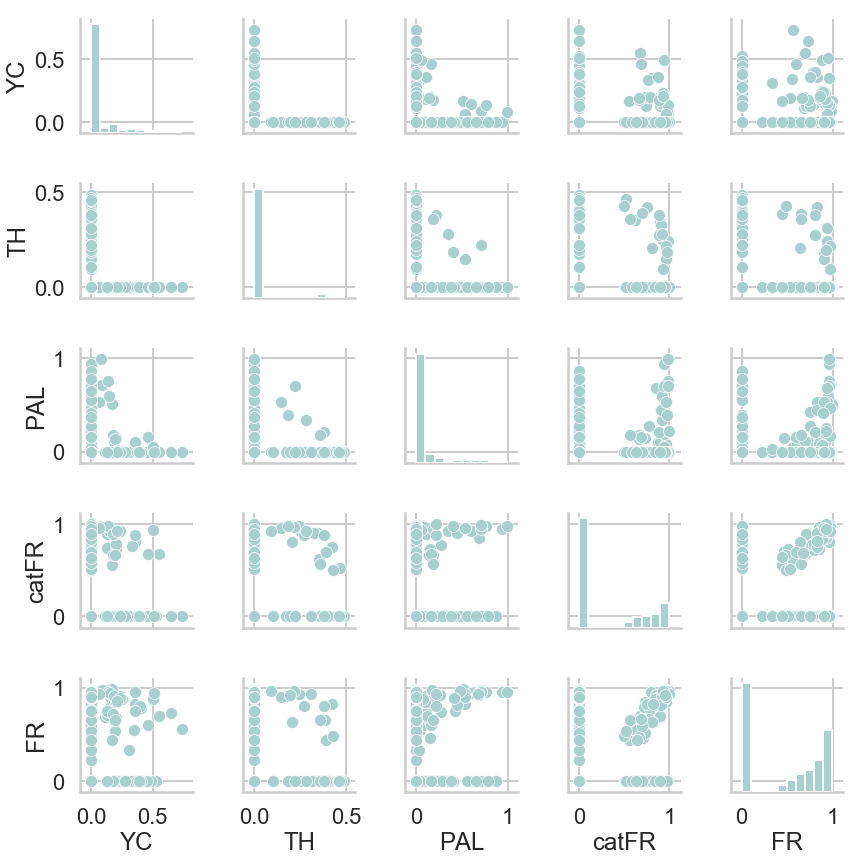

In [190]:
sns.pairplot(data=task_data.fillna(0), vars=['YC','TH','PAL','catFR','FR'])

In [191]:
# add averages over recal and nav tasks
task_data = task_data.assign(recall = task_data[['catFR','FR','PAL']].mean(axis=1, skipna=True))
task_data = task_data.assign(nav = task_data[['TH','YC']].mean(axis=1, skipna=True))
task_data = task_data.assign(scale_nav =  1 - task_data['nav'])
task_data = task_data.assign(avg = task_data[['scale_nav','recall']].mean(axis=1, skipna=True))
task_data.head()

subj        YC  TH       PAL  catFR        FR    recall       nav  \
0  R1001P  0.345526 NaN  0.041370    NaN  0.546573  0.293972  0.345526   
1  R1002P       NaN NaN  0.492335    NaN  0.945857  0.719096       NaN   
2  R1003P       NaN NaN  0.083711    NaN  0.602817  0.343264       NaN   
3  R1004D       NaN NaN       NaN  0.625       NaN  0.625000       NaN   
4  R1006P  0.401778 NaN       NaN    NaN  0.779412  0.779412  0.401778   

   scale_nav       avg  
0   0.654474  0.474223  
1        NaN  0.719096  
2        NaN  0.343264  
3        NaN  0.625000  
4   0.598222  0.688817

In [192]:
# count missing values again
task_data.apply(lambda x: sum(x.isnull())/x.size*100, axis=0)

subj          0.000000
YC           78.597786
TH           86.715867
PAL          76.014760
catFR        62.730627
FR           40.959410
recall       18.819188
nav          65.313653
scale_nav    65.313653
avg           8.487085
dtype: float64

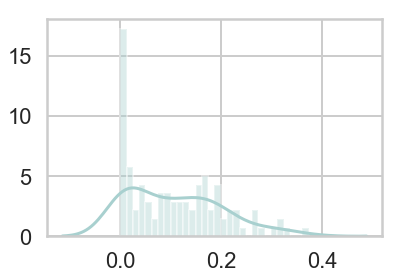

In [193]:
# Are subjects variable across tasks? 
var = pd.core.nanops.nanvar(task_data[['TH', 'YC', 'PAL', 'FR', 'catFR']], axis=1)
var = var[task_data[['TH', 'YC', 'PAL', 'FR', 'catFR']].isna().sum(axis=1) <= 3]
sns.distplot(var, bins=30)

In [194]:
# merge with net_data
subj_idx = [x in net_data.subj.unique() for x in task_data.subj]
task_data = task_data[subj_idx]
net_data = pd.merge(net_data, task_data, on=['subj'], how = 'outer')
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5910 entries, 0 to 5909
Data columns (total 65 columns):
band_measure              5910 non-null object
n_tp                      5910 non-null int64
str_beta_bin              5767 non-null float64
str_beta_num              5780 non-null float64
str_beta_spr              5795 non-null float64
ti_beta_bin               5776 non-null float64
ti_beta_num               5785 non-null float64
ti_beta_spr               5793 non-null float64
str_soz_beta_bin          3975 non-null float64
str_soz_beta_num          3974 non-null float64
str_soz_beta_spr          3980 non-null float64
str_not_soz_beta_num      3979 non-null float64
str_spike_beta_num        3616 non-null float64
str_not_soz_beta_spr      3971 non-null float64
str_not_soz_beta_bin      3958 non-null float64
str_spike_beta_bin        3615 non-null float64
str_spike_beta_spr        3622 non-null float64
str_not_spike_beta_bin    3605 non-null float64
Measure                   5910 n

In [195]:
net_data.subj.nunique()

144

In [196]:
# save
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_task_data_clean{detector}.csv')

## Demographics

In [197]:
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5910 entries, 0 to 5909
Data columns (total 65 columns):
band_measure              5910 non-null object
n_tp                      5910 non-null int64
str_beta_bin              5767 non-null float64
str_beta_num              5780 non-null float64
str_beta_spr              5795 non-null float64
ti_beta_bin               5776 non-null float64
ti_beta_num               5785 non-null float64
ti_beta_spr               5793 non-null float64
str_soz_beta_bin          3975 non-null float64
str_soz_beta_num          3974 non-null float64
str_soz_beta_spr          3980 non-null float64
str_not_soz_beta_num      3979 non-null float64
str_spike_beta_num        3616 non-null float64
str_not_soz_beta_spr      3971 non-null float64
str_not_soz_beta_bin      3958 non-null float64
str_spike_beta_bin        3615 non-null float64
str_spike_beta_spr        3622 non-null float64
str_not_spike_beta_bin    3605 non-null float64
Measure                   5910 n

In [198]:
# add institution
def get_inst(subj):
    if subj[-1] == 'J':
        net_data[net_data['subj'] == subj]['Institution'] = 'Jeff'
    elif subj[-1] == 'P':
        net_data[net_data['subj'] == subj]['Institution'] = 'Penn'
    elif subj[-1] == 'M':
        net_data[net_data['subj'] == subj]['Institution'] = 'Mayo'
    elif subj[-1] == 'C':
        net_data[net_data['subj'] == subj]['Institution'] = 'Columbia'
    elif subj[-1] == 'E':
        net_data[net_data['subj'] == subj]['Institution'] = 'Emory'
    elif subj[-1] == 'D':
        net_data[net_data['subj'] == subj]['Institution'] = 'Dartmouth'
    elif subj[-1] == 'N':
        net_data[net_data['subj'] == subj]['Institution'] = 'NINDS'
    else:
        net_data.loc[net_data['subj'] == subj,'Institution'] = subj[-1]
        
for s in net_data[net_data['Institution'].isna()]['subj'].values:
    get_inst(s)

In [199]:
sum(net_data['Institution'].isna())

0

In [200]:
print('Etiology: ' + str(net_data[[not x for x in net_data['Etiology'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('Education: ' + str(net_data[[not x for x in net_data['Education'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('Institution: ' + str(net_data[[not x for x in net_data['Institution'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('Lesional: ' + str(net_data[[not x for x in net_data['Lesional'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('SeizureAge: ' + str(net_data[[not x for x in net_data['SeizureAge'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('locus: ' + str(net_data[[not x for x in net_data['locus'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('hem: ' + str(net_data[[not x for x in net_data['hem'].isna()]]['subj'].nunique()/net_data.subj.nunique()))
print('avg: ' + str(net_data[[not x for x in net_data['avg'].isna()]]['subj'].nunique()/net_data.subj.nunique()))


Etiology: 0.7916666666666666
Education: 0.6458333333333334
Institution: 1.0
Lesional: 0.8680555555555556
SeizureAge: 0.8402777777777778
locus: 0.7638888888888888
hem: 0.7638888888888888
avg: 0.9722222222222222


In [201]:
# add most common etiology (unkown) and education to missing data
net_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5910 entries, 0 to 5909
Data columns (total 65 columns):
band_measure              5910 non-null object
n_tp                      5910 non-null int64
str_beta_bin              5767 non-null float64
str_beta_num              5780 non-null float64
str_beta_spr              5795 non-null float64
ti_beta_bin               5776 non-null float64
ti_beta_num               5785 non-null float64
ti_beta_spr               5793 non-null float64
str_soz_beta_bin          3975 non-null float64
str_soz_beta_num          3974 non-null float64
str_soz_beta_spr          3980 non-null float64
str_not_soz_beta_num      3979 non-null float64
str_spike_beta_num        3616 non-null float64
str_not_soz_beta_spr      3971 non-null float64
str_not_soz_beta_bin      3958 non-null float64
str_spike_beta_bin        3615 non-null float64
str_spike_beta_spr        3622 non-null float64
str_not_spike_beta_bin    3605 non-null float64
Measure                   5910 n

In [202]:
net_data.to_csv(f'{RAM_dir}group_analysis/win_{win}/net_dem_data{detector}.csv')

In [203]:
net_data.subj.nunique()

144